# Банки - анализ оттока клиентов.

https://disk.yandex.ru/d/KzUpa65CHSKaxw

Цель работы - выделить сегменты клиентов, которые склонны уйти из Банка; дать рекомендации по удержанию этих клиентов.

Нам предоставлены данные о клиентах Банка "Метанпром", филиалы которого расположены в городах: Ярославль, Новгород Великий, Рыбинск.

Описание датасета: Колонки:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

Для достижения поставленной цели будут проведены следующие мероприятия:

1. Проведение исследовательского анализа данных;

2. Сегментация клиентов на основе данных о наличии кредитной карты;

3. Формулировка и проверка статистических гипотез:

- гипотезы различия дохода между теми клиентами, которые ушли, и теми, которые остались.
- гипотезы различия в факте наличия кредитной карты между теми клиентами, которые ушли, и теми, которые остались.

По результатам исследования будет сформирован дашборд: 
- Строим диаграмму, отображающую распределение заработной платы клиентов.
- Добавляем индикатор, отображающий процент клиентов, имеющих кредитную карту.
- Добавляем фильтр дашборда, позволяющий выбрать ушёл клиент или нет.

Для конечного заказчика будет составлена презентация.

## Откроем файл и изучим общую информацию:

Для начала подгрузим все библиотеки, которые могут нам пригодиться:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import plotly.express as px

from scipy import stats as st
from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

register_matplotlib_converters()


Назовет наш датасет data и прочитаем его:

In [2]:
data = pd.read_csv('bank_dataset.csv')
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


В таблице 1000 клиентов - количество, достаточное для проведения анализа. По каждому клиенту предоставлена следующая информация: идентификационный номер клиента, кредитный скоринг, город, пол, возраст, количество объектов собственности, баланс (в этом столбце мы видим наличие пропусков, с которыми будем работать в следующем разделе), количество продуктов у клиента в банке, наличие кредитной карты, активность, заработная плата и информация о том, ушёл клиент из банка или нет. Приступим к предобработке данных.

## Предобработка данных.

### Названия столбцов:

In [4]:
data.columns.to_list()

['userid',
 'score',
 'City',
 'Gender',
 'Age',
 'Objects',
 'Balance',
 'Products',
 'CreditCard',
 'Loyalty',
 'estimated_salary',
 'Churn']

Приведем все названия к читабельному формату с соблюдением стилевых требований:

In [5]:
data.columns = ['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn']
data = data[['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn']]
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Типы данных:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Столбцы gender, credit_card, loyalty, churn можно было бы привести к формату с булевыми значениями, но я не вижу в этом необходимости, так что предлагаю оставить как есть, остальные колонки по содержанию соответствуют типам данных.

### Проверка на  дубликаты:

In [7]:
data.duplicated().sum()

0

Явных дубликатов нет, посмотрим, какие уникальные значения имеются в столбцах:

In [8]:
data['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [9]:
data['objects'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: objects, dtype: int64

In [10]:
data['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

In [11]:
data['credit_card'].value_counts()

1    7055
0    2945
Name: credit_card, dtype: int64

Клиент может жить в одном из трёх городов (Ярославль, Ростов Великий, Рыбинск), у него может быль от 0 до 10 объектов собственности, от 1 до 4 продуктов банка, у нас 7055 владельцев кредитной карты и 2945 клиентов без кредитной карты. Скрытых дубликатов тут тоже нет.

### Пропуски в данных:

In [12]:
data.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

3617 пропусков в столбце "balance" - это более 35% пропущенных данных. Оставить пропуски незаполненными считаю нецелесообразным. Посмотрим, чем отличаются клиенты, у которых баланс заполнен, от тех, у кого в этом столбце пропуски. Сначала выведем первые строки таблицы с клиентами, у которых не заполнено значение balance:

In [13]:
data_no_balances = data[data['balance'].isnull()]
data_no_balances.head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0


Теперь первые строки таблицы с клиентами, у которых заполнено значение balance:

In [14]:
data[data['balance'].notnull()].head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1


In [15]:
data_no_balances.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,3.617000e+03,3617.000000,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,1.573469e+07,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236
std,7.194749e+04,96.158798,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195
min,1.560844e+07,350.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000
25%,1.567226e+07,583.000000,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000
50%,1.573608e+07,651.000000,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000
75%,1.579629e+07,717.000000,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000
max,1.585810e+07,850.000000,88.000000,10.000000,NaN,4.000000,1.000000,1.000000,199992.480000,1.000000


In [16]:
data_no_balances['city'].unique()

array(['Ярославль', 'Рыбинск'], dtype=object)

In [17]:
data_no_balances['products'].unique()

array([1, 2, 3, 4], dtype=int64)

In [18]:
data_no_balances['credit_card'].unique()

array([1, 0], dtype=int64)

Получается, что никаких критических различий нет, кроме того, что ни у одного клиента из Ростова Великого пропусков в этом столбце нет. Кроме того выяснилосьь, что минимальное значение в столбце "estimated_salary" (заработная плата) очень подозрительное - 90,070000 - это очень мало. Предлагаю промониторить МРОТ на изучаемый период (он нам неизвестен, но я предлагаю ориентироваться на 2019 год, т.к. большинство заданий курса имели приблизительно такой временной диапазон). Это значение составляет 9489 рублей. Нам теперь надо отсеять клиентов с зарплатой меньше этого значения, чтобы не происходило искажения данных.

In [19]:
data.query('estimated_salary < 9489').describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,4.770000e+02,477.000000,477.000000,477.000000,282.000000,477.000000,477.000000,477.000000,477.000000,477.000000
mean,1.573016e+07,647.882600,38.788260,4.704403,118114.598262,1.536688,0.670860,0.507338,4651.451992,0.205451
std,7.212857e+04,96.716095,10.565682,2.875323,28257.246126,0.577243,0.470394,0.500471,2790.059271,0.404455
min,1.560895e+07,413.000000,18.000000,0.000000,27517.150000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.566845e+07,583.000000,31.000000,2.000000,99365.925000,1.000000,0.000000,0.000000,2168.130000,0.000000
50%,1.572783e+07,646.000000,37.000000,4.000000,118397.120000,1.000000,1.000000,1.000000,4493.120000,0.000000
75%,1.579070e+07,710.000000,44.000000,7.000000,134942.070000,2.000000,1.000000,1.000000,6985.340000,0.000000
max,1.585816e+07,850.000000,77.000000,10.000000,204510.940000,4.000000,1.000000,1.000000,9468.640000,1.000000


In [20]:
print('Количество строк до удаления выбросов:', len(data))

Количество строк до удаления выбросов: 10000


In [21]:
data = data[data['estimated_salary'] >= np.percentile(data['estimated_salary'], 2)]
print('Количество строк после удаления выбросов:', len(data))

Количество строк после удаления выбросов: 9800


Получилось, что мы отсеяли 200 пользователей. Теперь предлагаю сфокусировать внимание на пропусках в столбце balance:

In [22]:
data['balance'].min()

3768.69

In [23]:
data['balance'].max()

250898.09

<AxesSubplot:>

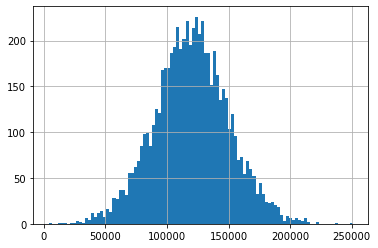

In [24]:
data['balance'].hist(bins=100)

In [25]:
data['balance'].describe()

count      6269.000000
mean     119865.910086
std       30085.320496
min        3768.690000
25%      100249.410000
50%      119919.120000
75%      139532.340000
max      250898.090000
Name: balance, dtype: float64

Распределение нормальное, стандартное отклонение незначительное. В этом случае считаю логичным заменить пропуски медианным значением.

In [26]:
data['balance'] = data['balance'].fillna(data['balance'].median())
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,119919.12,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,119919.12,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Промежуточные выводы:

- в таблице нет ни явных, ни скрытых дубликатов

- есть пропуски в столбце balance, которые мы заполнили медианным значением, по какой-то причине пропусков среди клиентов, проживающих в Ростове Великом, не было (склонна видеть причиной человеческий фактор - возможно сотрудники не заполнили данные или сам клиент не захотел указывать данные)

- клиентов с очевидно заниженными данными по заработной плате мы отсеяли, приняв за ориентир МРОТ в 2019 году. Зарплату ниже клиент по законодательству получать не может.

- типы данных мы оставили актуальными, внесли изменения в названия столбцов таблицы

## Исследовательский анализ данных.

Для начала посмотрим, как распределены признаки, указаныые в столбцах, между клиентами, которые ушли, и клиентами, которые остались.

In [27]:
data.groupby('churn').agg('mean').T

churn,0,1
user_id,1.573417e+07,1.573303e+07
score,6.517574e+02,6.452056e+02
age,3.741201e+01,4.482535e+01
objects,5.039379e+00,4.924152e+00
balance,1.197388e+05,1.204543e+05
products,1.542971e+00,1.478044e+00
credit_card,7.070292e-01,7.000998e-01
loyalty,5.550282e-01,3.602794e-01
estimated_salary,1.018336e+05,1.031092e+05


0 - клиент остался в Банке, 1 - клиент ушёл. Какие выводы можно сделать из увиденного:

- средний возраст ушедших клиентов - 45 лет, у оставшихся - 37
- активность оставшихся клиентов выше, активности ушедших, что вполне логично
- скоринговый бал практически одинаковый
- наличие кредитной карты, количество объектов недвижимости в собственности, остаток средств на балансе и ЗП в обеих группах практически не отличаются

### Предлагаю для категориальных данных построить столбчатые диаграммы, для количественных (числовых) - гистограммы. Так же нам потребуются диаграммы размаха.

Сначала напишем функцию для построения гистограммы распределения и диаграммы размаха для количественных признаков. Назовём её numeric_sign:

In [28]:
def numeric_sign(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))
    
    sns.histplot(df[df['churn']==0][col], color = '#ea33b1', ax = plt.subplot(1, 2, 1))
    sns.histplot(df[df['churn']==1][col], label = 'отток', color = '#ffc0cb', ax = plt.subplot(1, 2, 1), alpha=.4)
    plt.xlabel('')
    plt.ylabel('количество пользователей')
    plt.legend()
    
    sns.boxplot(y = col, x = 'churn', data = df, ax = plt.subplot(1, 2, 2), palette='Accent_r') 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2), ('Действующие клиенты', 'Отток'))
    
    fig.suptitle(title + ' (' + col + ')')
    plt.show()

Теперь функция для построения столбчатых диаграмм и диаграммы размаха для категориальных признаков. Назовём её categorical_sign:

In [29]:
def categorical_sign(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))

    sns.countplot(x = col, hue = 'churn', data = df, ax = plt.subplot(1, 2, 1),  palette='Accent')
    plt.ylabel('количество пользователей')
    plt.xlabel('')
    plt.legend() 
    
    gr = df.groupby([col, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = col, y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Accent_r') 
    plt.xlabel('')
    plt.ylabel('')
    
    
    fig.suptitle(title + ' (' + col + ')')
    plt.show()

Собираем названия колонок и графиков в датафрейм:

In [30]:
numeric = pd.DataFrame({'col' : ['score', 'age', 'objects', 'balance', 'products', 'estimated_salary'], 
                        'title' : ['Кредитный скорринг', 'Возраст', 
                                   'Количество объектов недвижимости в собственности', 
                                   'Баланс', 'Количество продуктов', 
                                   'Заработная плата']
                       })

categorical = pd.DataFrame({'col' : ['gender', 'city', 'credit_card', 'loyalty'],
                            'title' : ['Пол', 'Город', 'Наличие кредитной карты', 'Активность']
                            })

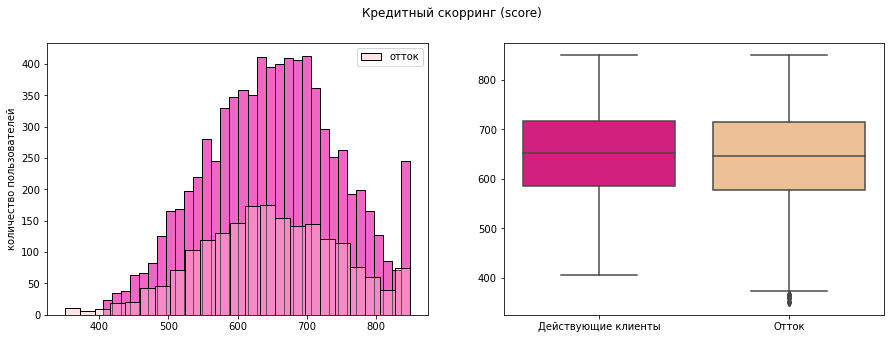

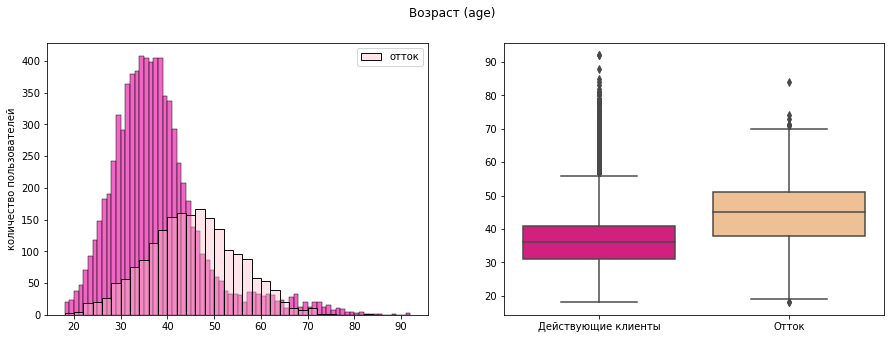

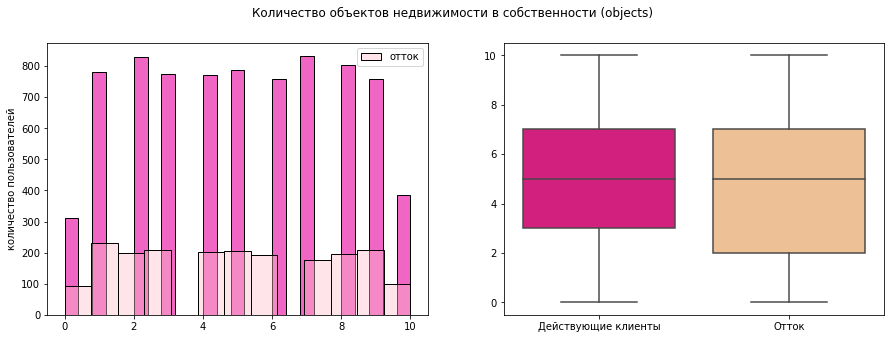

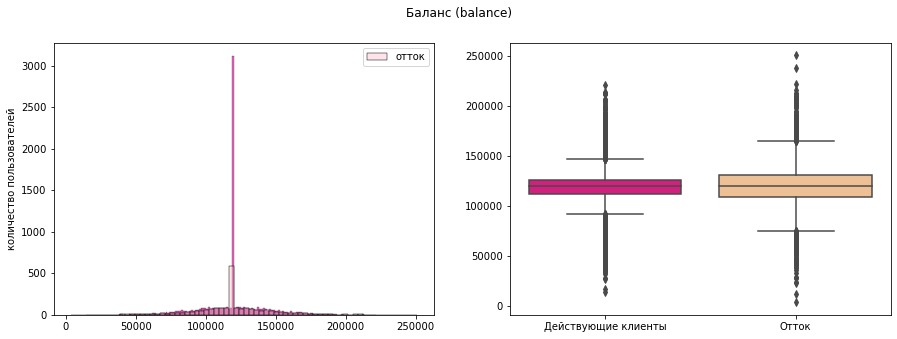

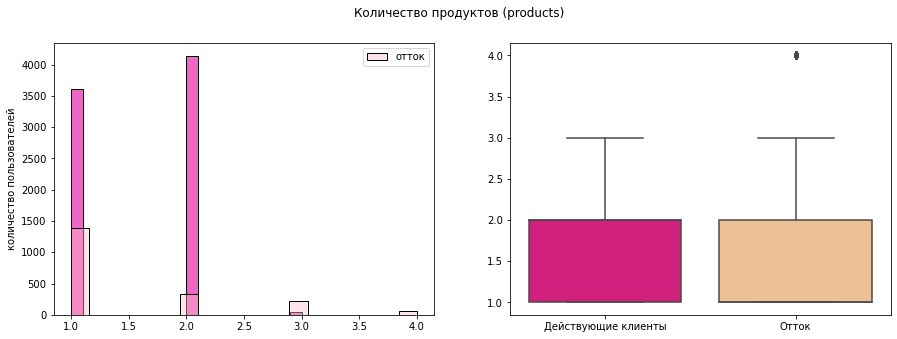

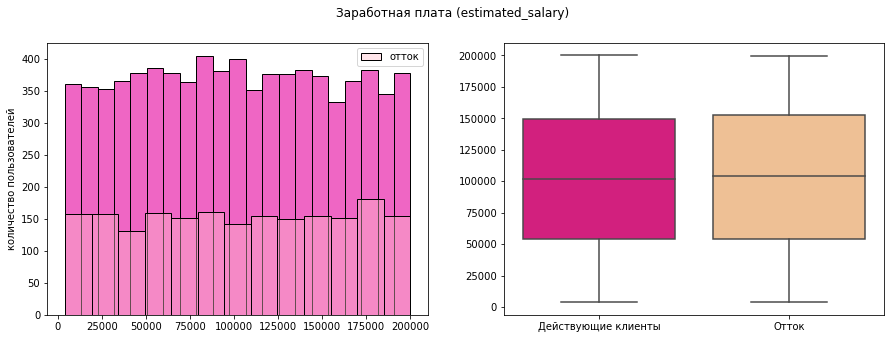

In [31]:
for index, row in numeric.iterrows():
    numeric_sign(data, row[0], row[1])

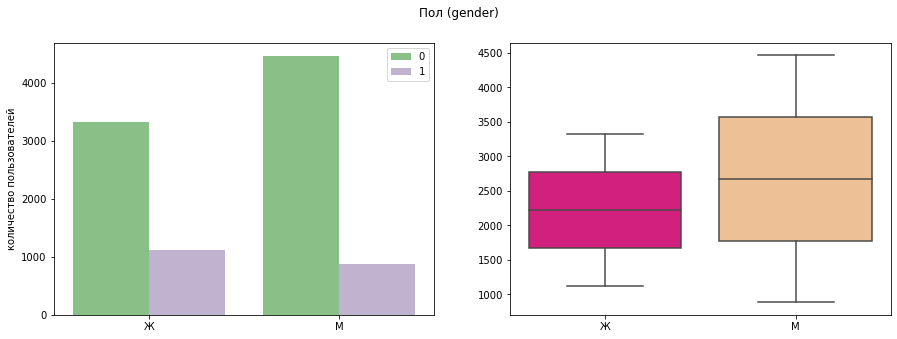

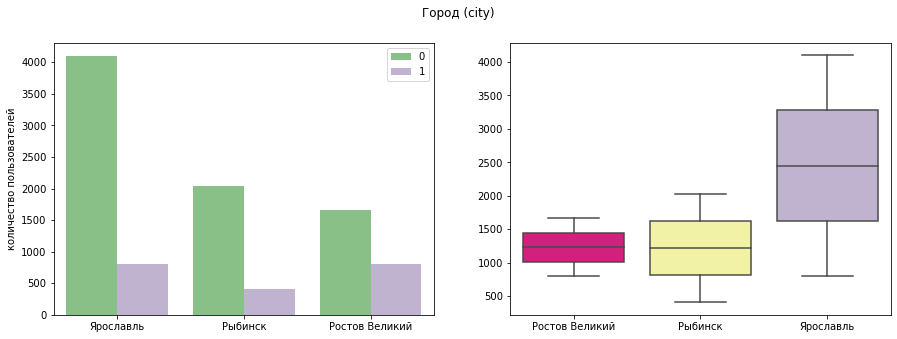

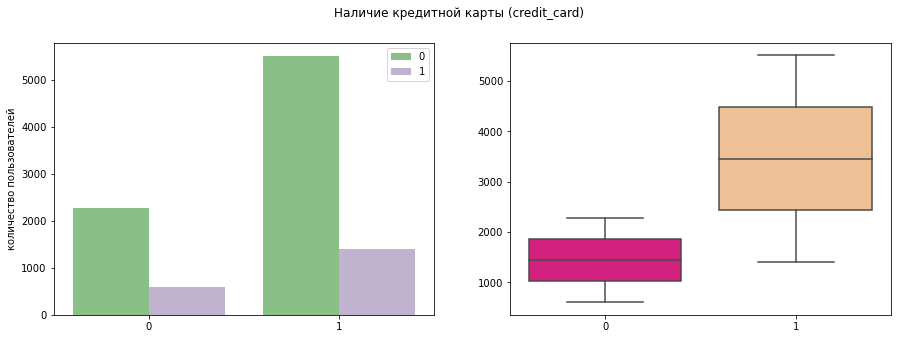

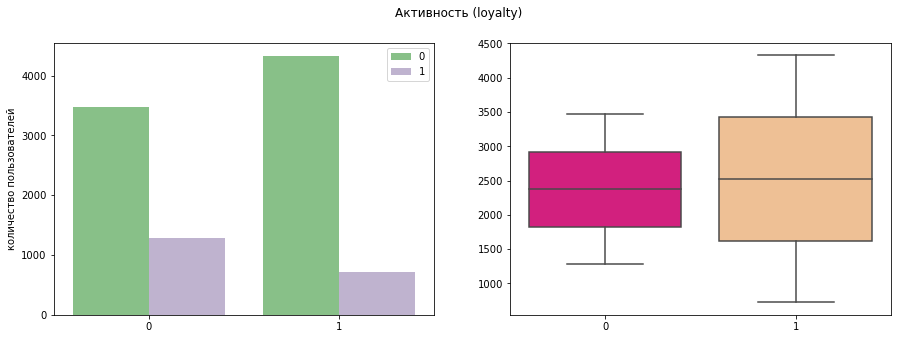

In [32]:
for index, row in categorical.iterrows():
    categorical_sign(data, row[0], row[1])

Графики показывают, что на отток влияют следующие признаки:

- наличие кредитной карты - держателей кредитный карт среди оставшихся клиентов гораздо больше, хотя и самих оставшихся клиентов больше;
- возраст (пик оттока -  40-50 лет);
- город (наблюдается странная аномалия в городе Ростов Великий - половина клиентов попадает в отток);
- количество используемых банковских продуктов (клиенты, использующие более 2х продуктов активно уходят);

Предлагаю так же взглянуть на матрицу корреляции признаков:

Применяю get_dummies, чтобы преобразовать категориальные столбцы (пол и город). Затем сохраняю преобразования в новом датафрейме matrix_data и строю матрицу:

In [33]:
matrix_data = pd.get_dummies(data, columns=['city', 'gender']).head()

In [34]:
matrix_data.head()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,15677338,619,42,2,119919.12,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,39,1,119919.12,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0


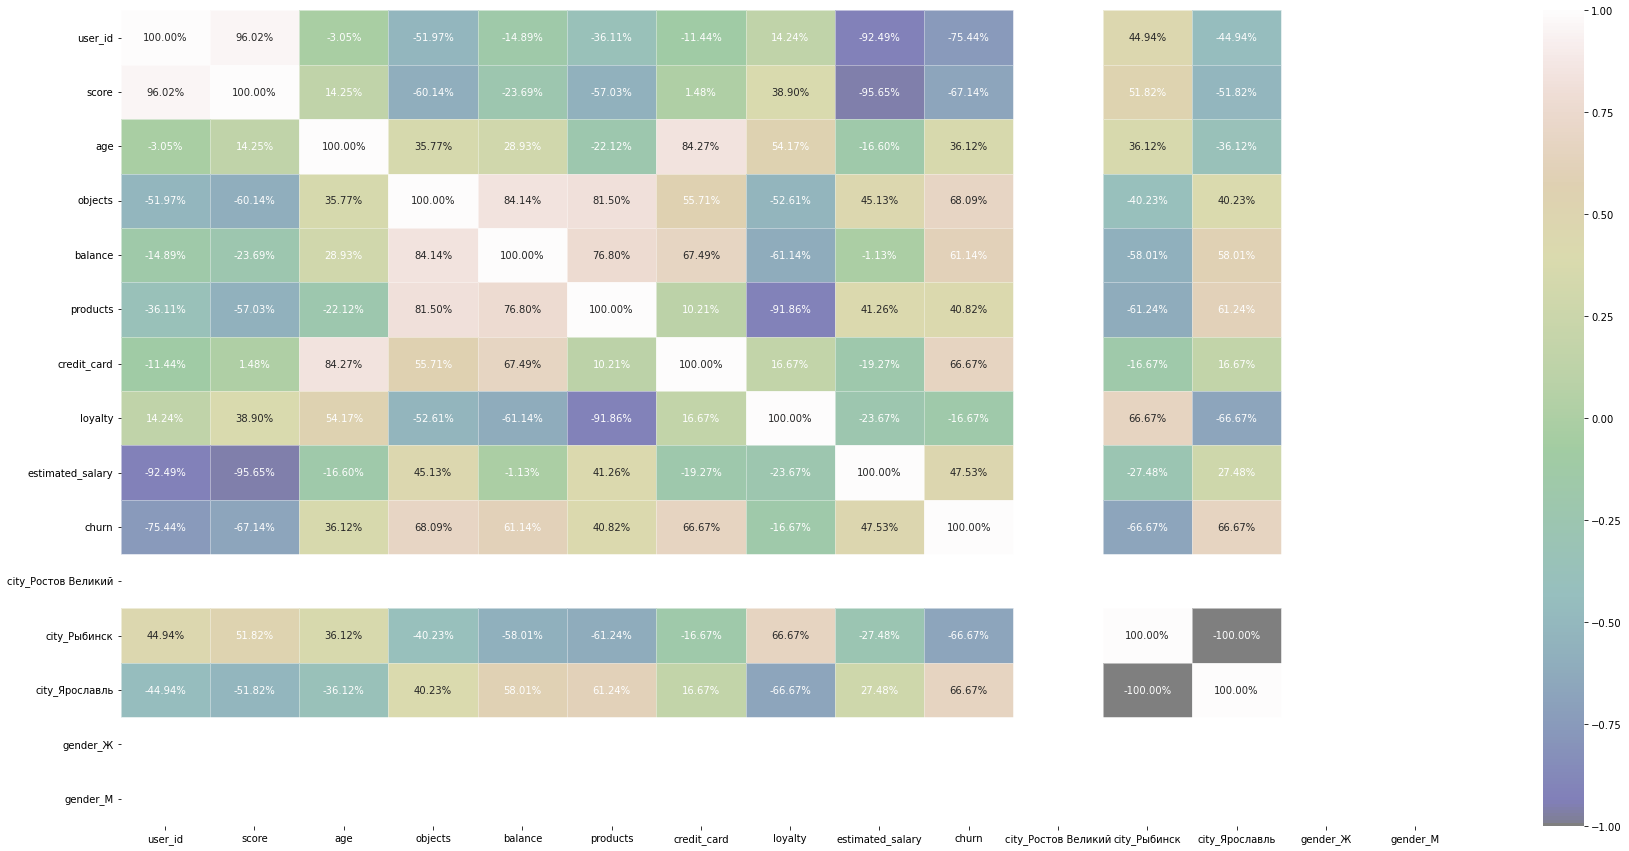

In [35]:
f, ax = plt.subplots(figsize=(30, 15))

sns.heatmap(matrix_data.corr(), annot=True, linewidths=.5, ax=ax, cmap='gist_earth',fmt='.2%', alpha=.5)
plt.show()

Мы видим, что, чем выше возраст, тем выше вероятность оттока. Так же очевидно (и вполне логично), что менее активные клиенты вероятнее всего скоро перестанут пользоваться услугами нашего Банка вовсе. В остальном очевидных зависимостей не просмотривается.

## Категоризация клиентов:

Создадим функцию, которая будет принимать датафрейм и возвращать гистограммы по признакам, а если указан столбец, то он будет исключен из графиков:

In [36]:
def feature_viz(data, column=None):
    
    features = ['score', 'gender', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn']
    if column != None:
        features.remove(column)
    number_row = int(len(features)/2)
    
    fig, ax = plt.subplots(nrows = number_row + 1 , ncols=2, figsize=(15, 20))
    ax = ax.flatten() # вытягиваем

    for i in range(len(features)):
        # в значении data укажем метод where(), чтобы заменить нулевые значения на пропуски 
        # для сохранения масштаба отображения баланса
        sns.histplot(data = data, x = data[features[i]], hue='churn', ax=ax[i], kde=True)
        ax[i].set_title(f'{features[i]}')
        ax[i].set_xlabel('')
     
    fig.delaxes(ax[-1])
    if column == None:
        fig.delaxes(ax[-2])    
    fig.tight_layout()

    fig.show()

### Категории клиентов по кредитному скорингу:

Создадим функцию, которая проверяет кол-во баллов клиента в нашем датафрейме и возвращает категорию (до 500, 500-700, более 700 баллов)

In [37]:
def score_category(data):
    if data['score'] <= 500:
        return 'Низкий уровень'
    elif (data['score'] >= 501 and data['score'] <= 700):
        return 'Средний уровень'
    else:
        return 'Высокий уровень'

Создадим новый столбец и применим функцию к датафрейму и выведем результат:

In [38]:
data['score_category'] = data.apply(score_category, axis=1)
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,score_category
0,15677338,619,Ярославль,Ж,42,2,119919.12,1,1,1,101348.88,1,Средний уровень
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,Средний уровень
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,Средний уровень
3,15744090,699,Ярославль,Ж,39,1,119919.12,2,0,0,93826.63,0,Средний уровень
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,Высокий уровень


Посмотрим, сколько клиентов попалло в каждую из наших категорий:

In [39]:
data['score_category'].value_counts()

Средний уровень    6121
Высокий уровень    3050
Низкий уровень      629
Name: score_category, dtype: int64

Выведем информацию и графики по категориям возраста

Распределение признаков для Низкого уровня


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,6.290000e+02,629.000000,629.000000,629.000000,629.000000,629.000000,629.00000,629.000000,629.000000,629.000000
mean,1.573463e+07,463.707472,39.077901,5.092210,120939.135262,1.515103,0.72496,0.464229,105942.890032,0.238474
std,7.382591e+04,30.314755,10.260243,2.816764,24658.479508,0.587972,0.44689,0.499116,56449.305783,0.426489
min,1.560877e+07,350.000000,19.000000,0.000000,33563.950000,1.000000,0.00000,0.000000,3937.370000,0.000000
25%,1.567284e+07,445.000000,32.000000,3.000000,111920.130000,1.000000,0.00000,0.000000,60972.840000,0.000000
50%,1.573374e+07,471.000000,37.000000,5.000000,119919.120000,1.000000,1.00000,0.000000,107067.370000,0.000000
75%,1.579565e+07,488.000000,45.000000,8.000000,130114.390000,2.000000,1.00000,1.000000,157333.690000,0.000000
max,1.585838e+07,500.000000,84.000000,10.000000,221532.800000,4.000000,1.00000,1.000000,199505.530000,1.000000


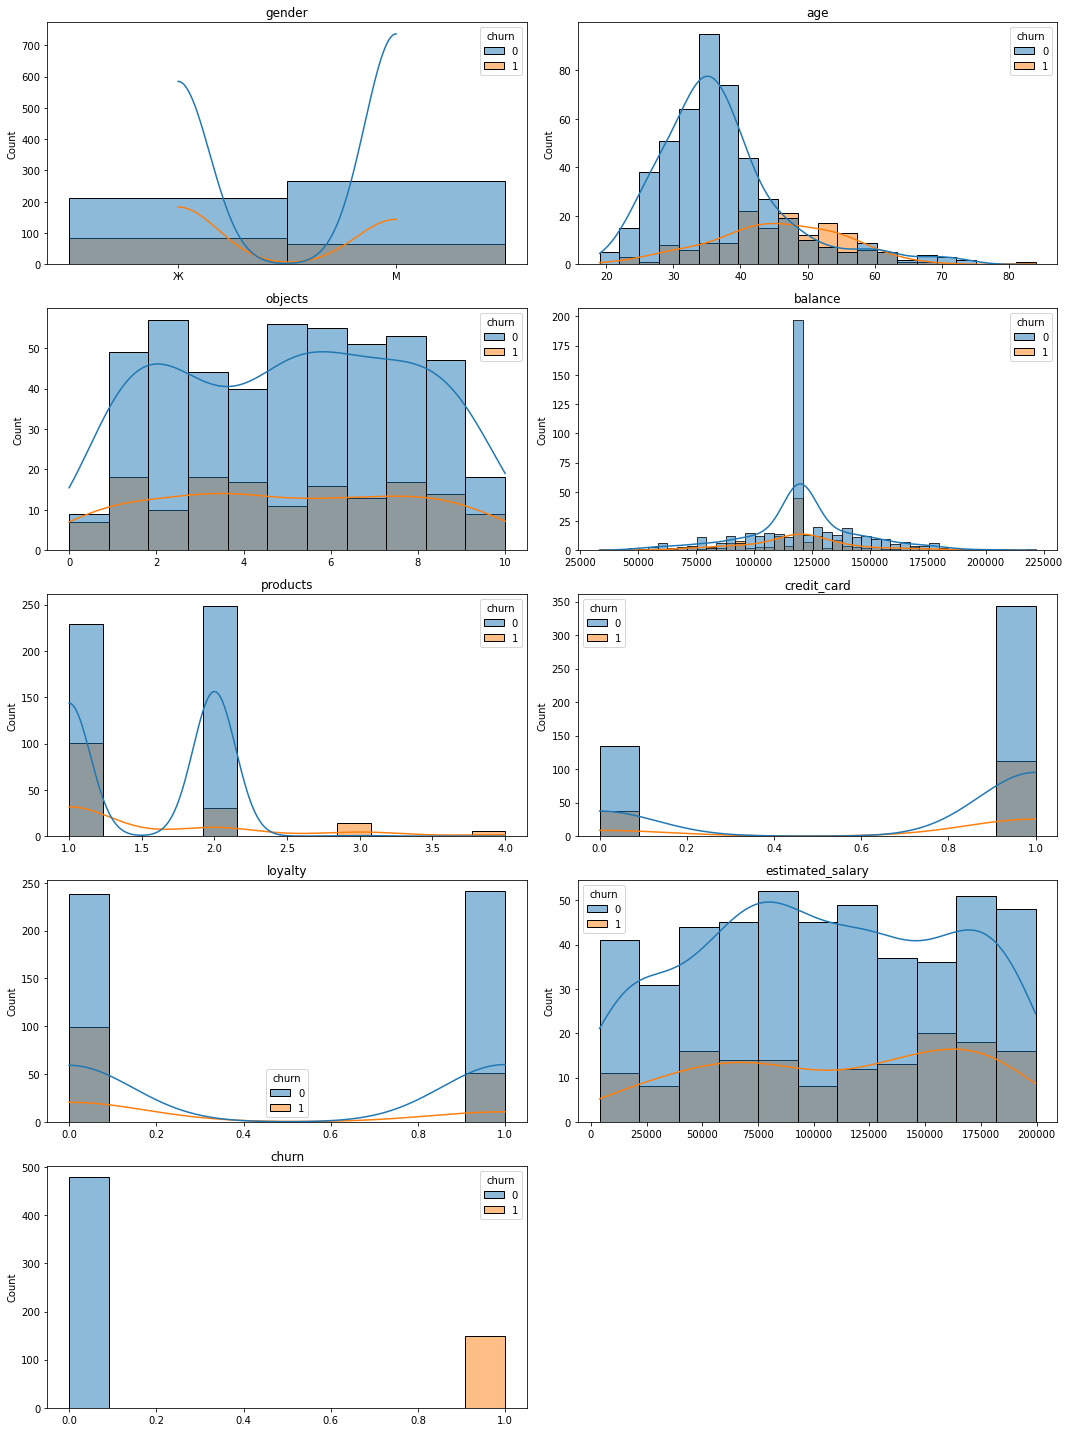

In [40]:
print('Распределение признаков для Низкого уровня')
feature_viz(data.query('score_category == "Низкий уровень"'), 'score')
display(data.query('score_category == "Низкий уровень"').describe())

Распределение признаков для Среднего уровня


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,6.121000e+03,6121.000000,6121.000000,6121.000000,6121.000000,6121.000000,6121.000000,6121.000000,6121.000000,6121.000000
mean,1.573326e+07,614.526058,38.974187,4.995589,119798.670023,1.528345,0.702990,0.514949,101554.194888,0.203562
std,7.162571e+04,53.765638,10.457336,2.895028,23966.968247,0.585686,0.456978,0.499817,56219.086703,0.402679
min,1.560844e+07,501.000000,18.000000,0.000000,12459.190000,1.000000,0.000000,0.000000,3815.480000,0.000000
25%,1.567086e+07,574.000000,32.000000,2.000000,111852.840000,1.000000,0.000000,0.000000,53222.150000,0.000000
50%,1.573318e+07,620.000000,37.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,101839.770000,0.000000
75%,1.579554e+07,660.000000,44.000000,7.000000,127631.620000,2.000000,1.000000,1.000000,149536.150000,0.000000
max,1.585843e+07,700.000000,88.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


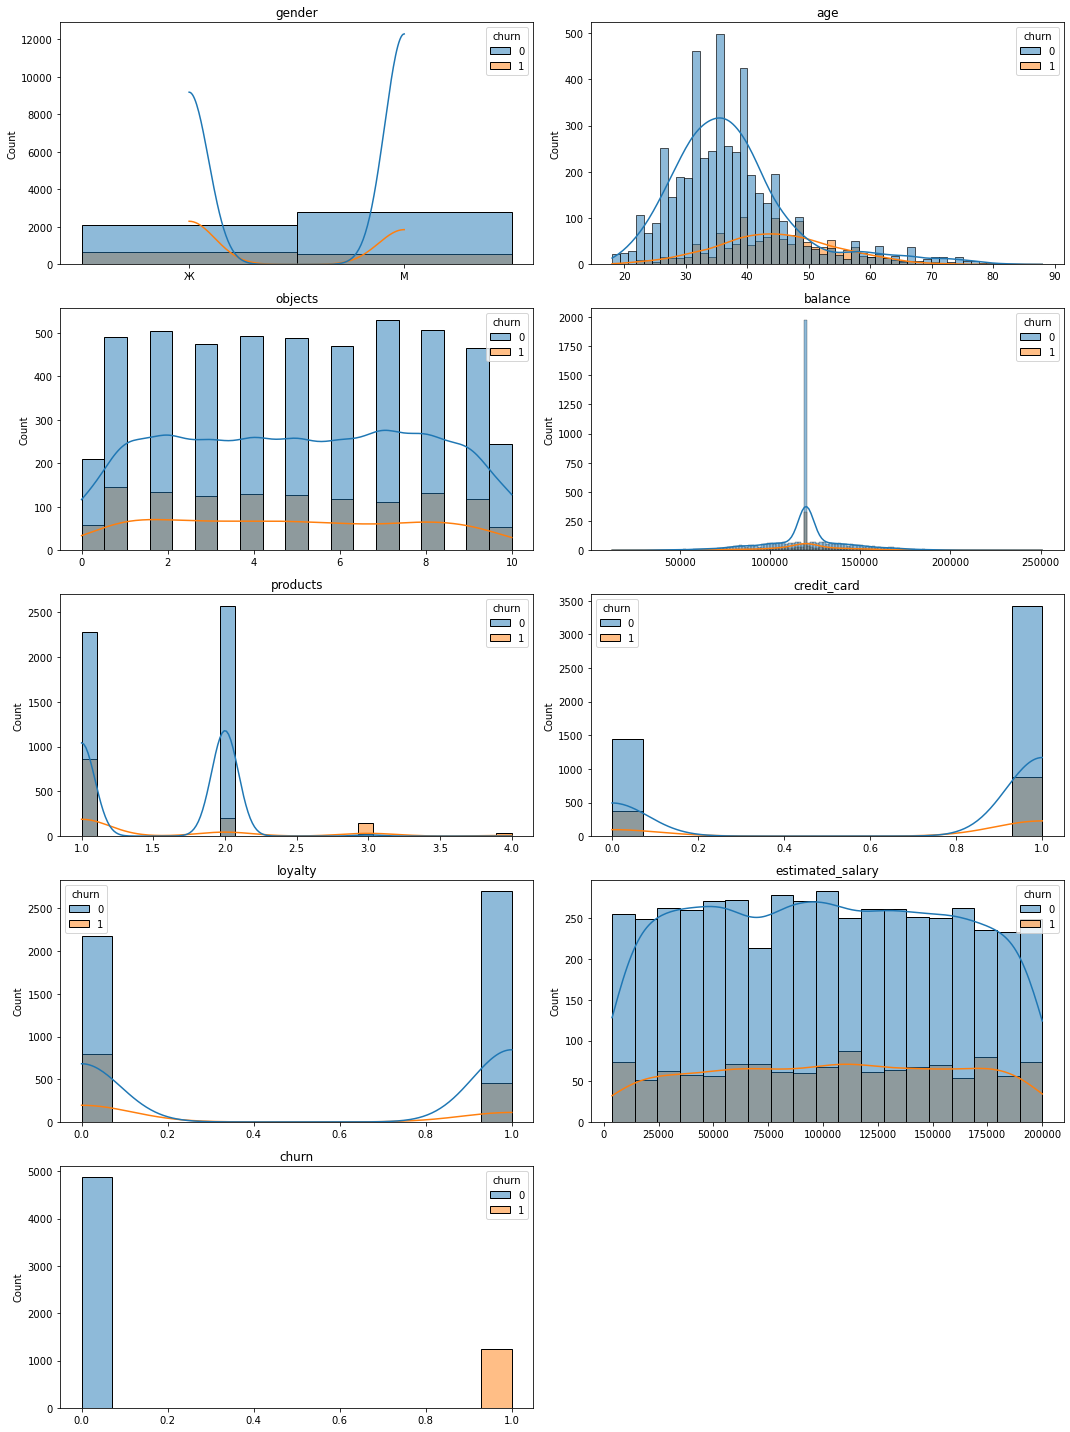

In [41]:
print('Распределение признаков для Среднего уровня')
feature_viz(data.query('score_category == "Средний уровень"'), 'score')
display(data.query('score_category == "Средний уровень"').describe())

Распределение признаков для Высокого уровня


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,3.050000e+03,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000
mean,1.573516e+07,760.953115,38.804262,5.040656,119841.123856,1.535410,0.706885,0.526230,102384.954410,0.199344
std,7.214613e+04,44.615504,10.596047,2.899936,24130.100972,0.576879,0.455265,0.499393,56541.605355,0.399573
min,1.560853e+07,701.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,3769.710000,0.000000
25%,1.567235e+07,723.000000,32.000000,3.000000,111061.690000,1.000000,0.000000,0.000000,54273.452500,0.000000
50%,1.573700e+07,752.000000,37.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,101556.215000,0.000000
75%,1.579792e+07,791.000000,44.000000,8.000000,127348.410000,2.000000,1.000000,1.000000,150663.565000,0.000000
max,1.585840e+07,850.000000,92.000000,10.000000,222267.630000,4.000000,1.000000,1.000000,199857.470000,1.000000


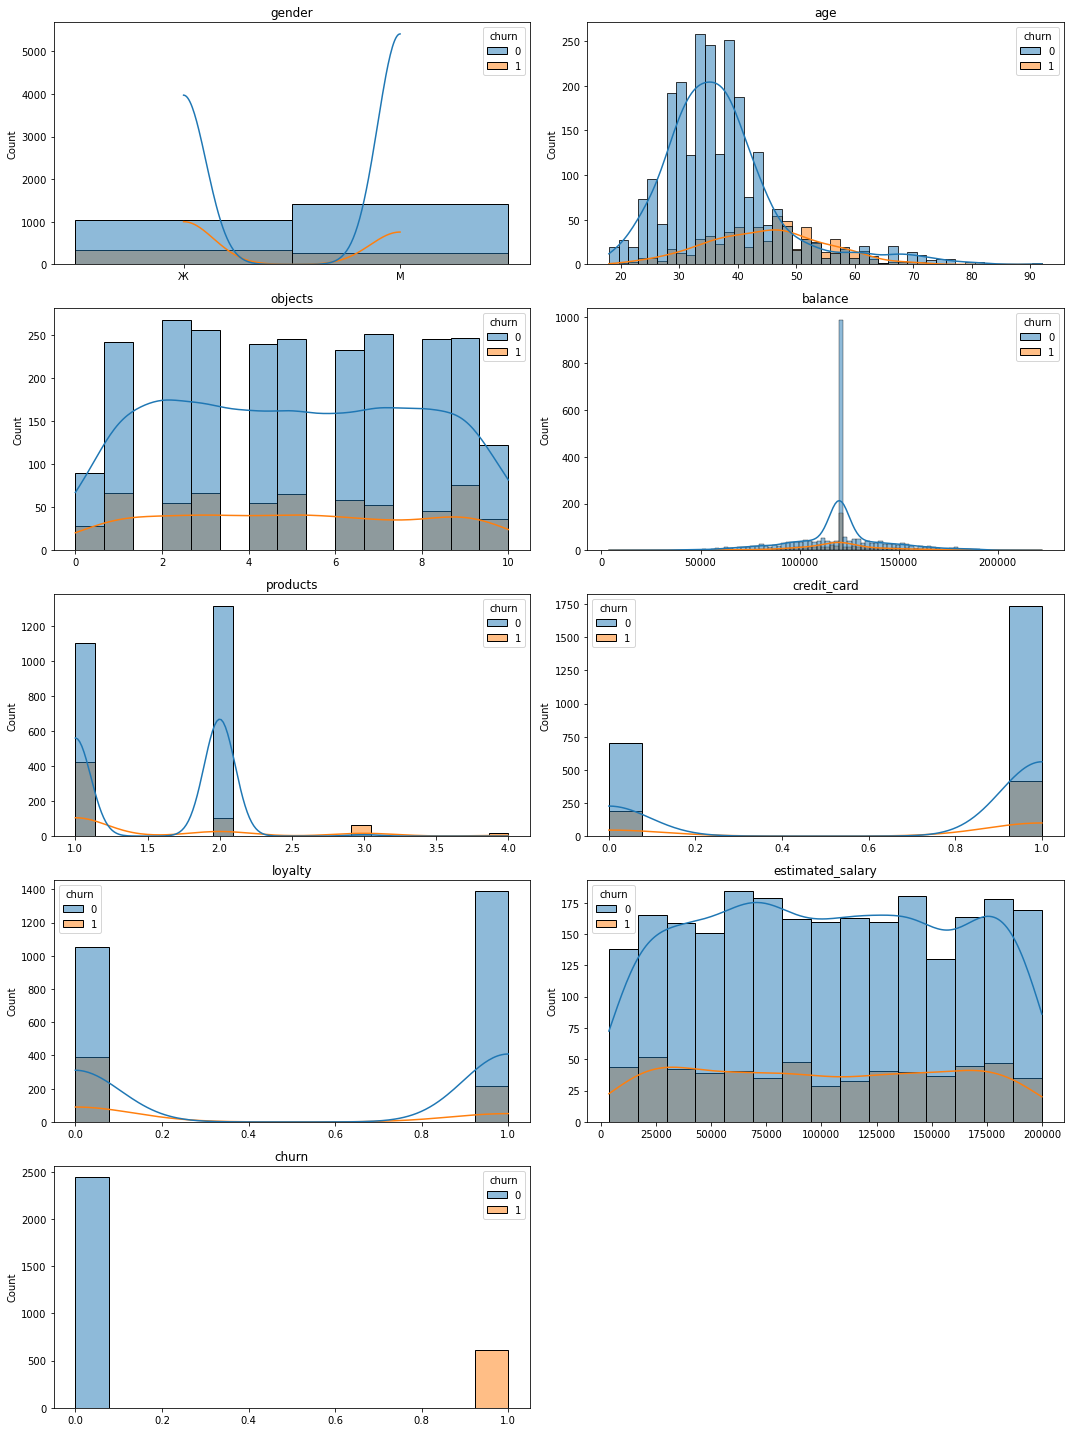

In [42]:
print('Распределение признаков для Высокого уровня')
feature_viz(data.query('score_category == "Высокий уровень"'), 'score')
display(data.query('score_category == "Высокий уровень"').describe())

Выводы:

Низкий скоринговый балл:
Кол-во клиентов в категории - 629
Средний отток - 24%

Средний скоринговый балл:
Кол-во клиентов в категории - 6121
Средний отток - 20%

Высокий скоринговый балл:
Кол-во клиентов в категории - 3050
Средний отток - 20%



### Категории клиентов по возрасту:

Создадим функцию, которая проверяет возраст клиента в нашем датафрейме и возвращает категорию (18-45 лет, 45-60 лет, старше 60):

In [43]:
def age_cat(data):
    if (data['age'] >= 18 and data['age'] <= 45):
        return '18-45'
    elif (data['age'] > 45 and data['age'] <= 60):
        return '46-60'
    else:
        return '61+'

Создадим новый столбец и применим функцию к датафрейму и выведем результат:

In [44]:
data['age_category'] = data.apply(age_cat, axis=1)
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,score_category,age_category
0,15677338,619,Ярославль,Ж,42,2,119919.12,1,1,1,101348.88,1,Средний уровень,18-45
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,Средний уровень,18-45
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,Средний уровень,18-45
3,15744090,699,Ярославль,Ж,39,1,119919.12,2,0,0,93826.63,0,Средний уровень,18-45
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,Высокий уровень,18-45


Посмотрим, сколько клиентов попало в каждую из категорий:

In [45]:
data['age_category'].value_counts()

18-45    7728
46-60    1616
61+       456
Name: age_category, dtype: int64

Теперь выведем информацию и графики по категориям возраста:

Распределение признаков для 18-45 лет


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,7.728000e+03,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000
mean,1.573357e+07,651.122283,34.671713,5.025492,119969.153226,1.540890,0.706263,0.496506,102258.843988,0.137293
std,7.183662e+04,96.281399,5.999505,2.880295,24045.196647,0.561603,0.455502,0.500020,56418.977708,0.344179
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,3769.710000,0.000000
25%,1.567094e+07,584.000000,31.000000,3.000000,112064.247500,1.000000,0.000000,0.000000,54276.117500,0.000000
50%,1.573413e+07,653.000000,35.000000,5.000000,119919.120000,2.000000,1.000000,0.000000,102180.065000,0.000000
75%,1.579565e+07,718.000000,39.000000,7.000000,127771.537500,2.000000,1.000000,1.000000,150224.192500,0.000000
max,1.585843e+07,850.000000,45.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


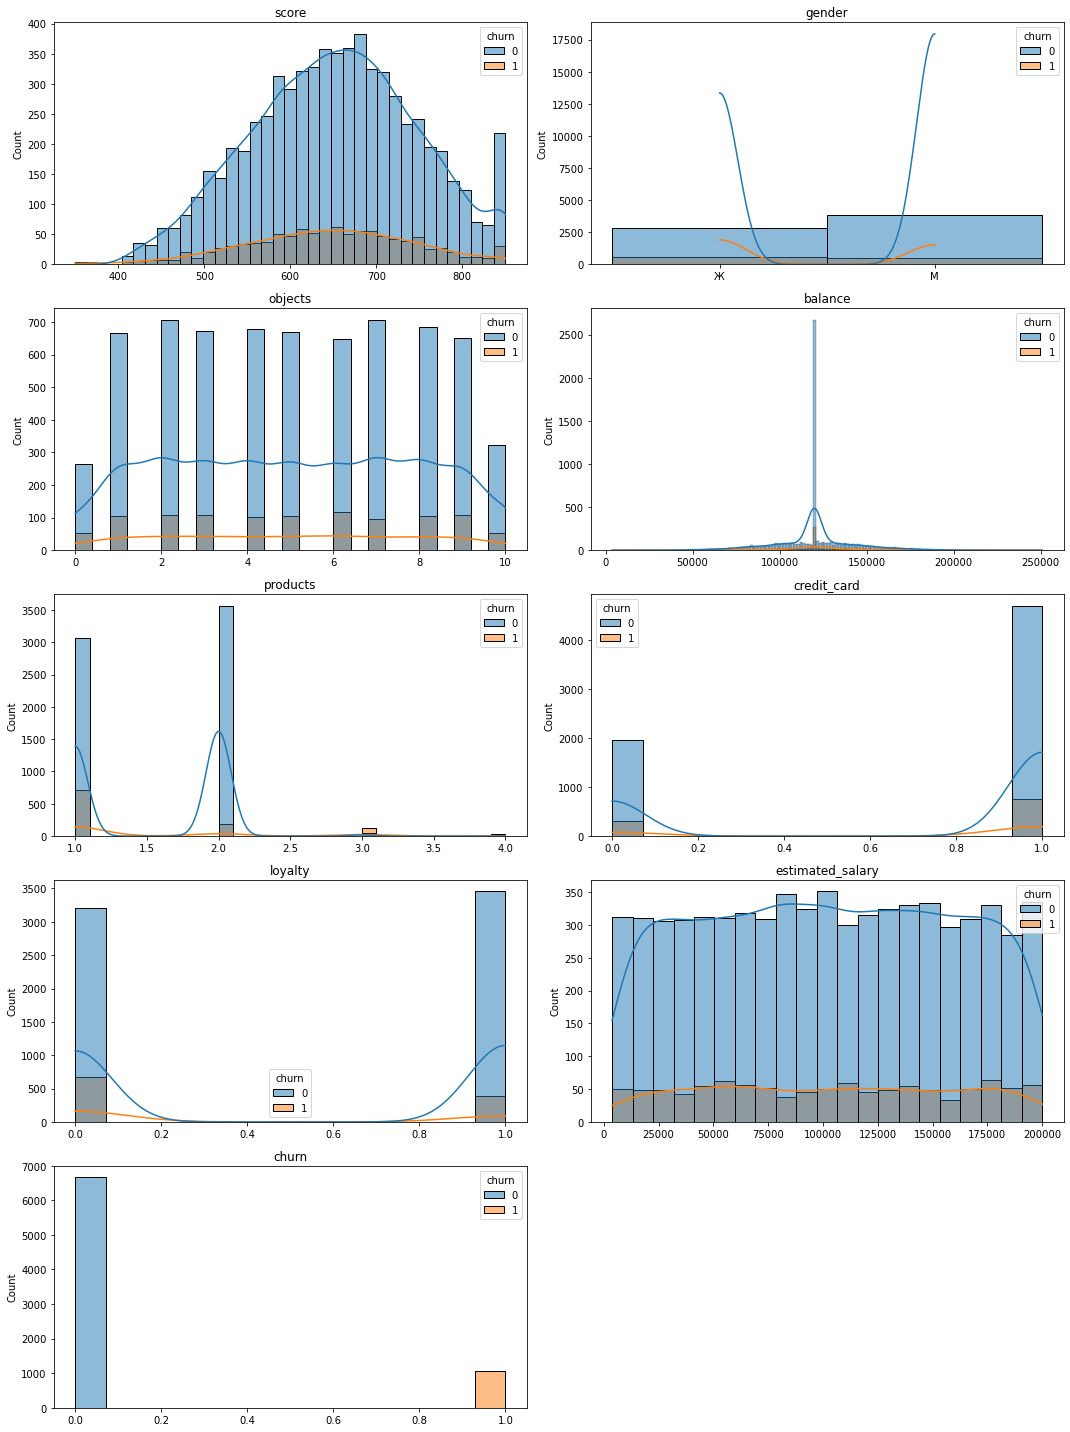

In [46]:
print('Распределение признаков для 18-45 лет')
feature_viz(data.query('age_category == "18-45"'), 'age')
display(data.query('age_category == "18-45"').describe())

Распределение признаков для 46-60 лет


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.616000e+03,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000
mean,1.573555e+07,646.182550,51.229579,5.000619,119725.759907,1.482673,0.702351,0.521658,101950.572420,0.513614
std,7.223342e+04,98.046862,4.255597,2.918395,24218.111231,0.672095,0.457366,0.499685,55902.296317,0.499969
min,1.560845e+07,350.000000,46.000000,0.000000,12459.190000,1.000000,0.000000,0.000000,3829.130000,0.000000
25%,1.567359e+07,581.000000,48.000000,2.000000,109695.007500,1.000000,0.000000,0.000000,54452.392500,0.000000
50%,1.573661e+07,647.000000,50.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,101356.255000,1.000000
75%,1.579794e+07,713.000000,55.000000,8.000000,127645.635000,2.000000,1.000000,1.000000,150217.605000,1.000000
max,1.585818e+07,850.000000,60.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199661.500000,1.000000


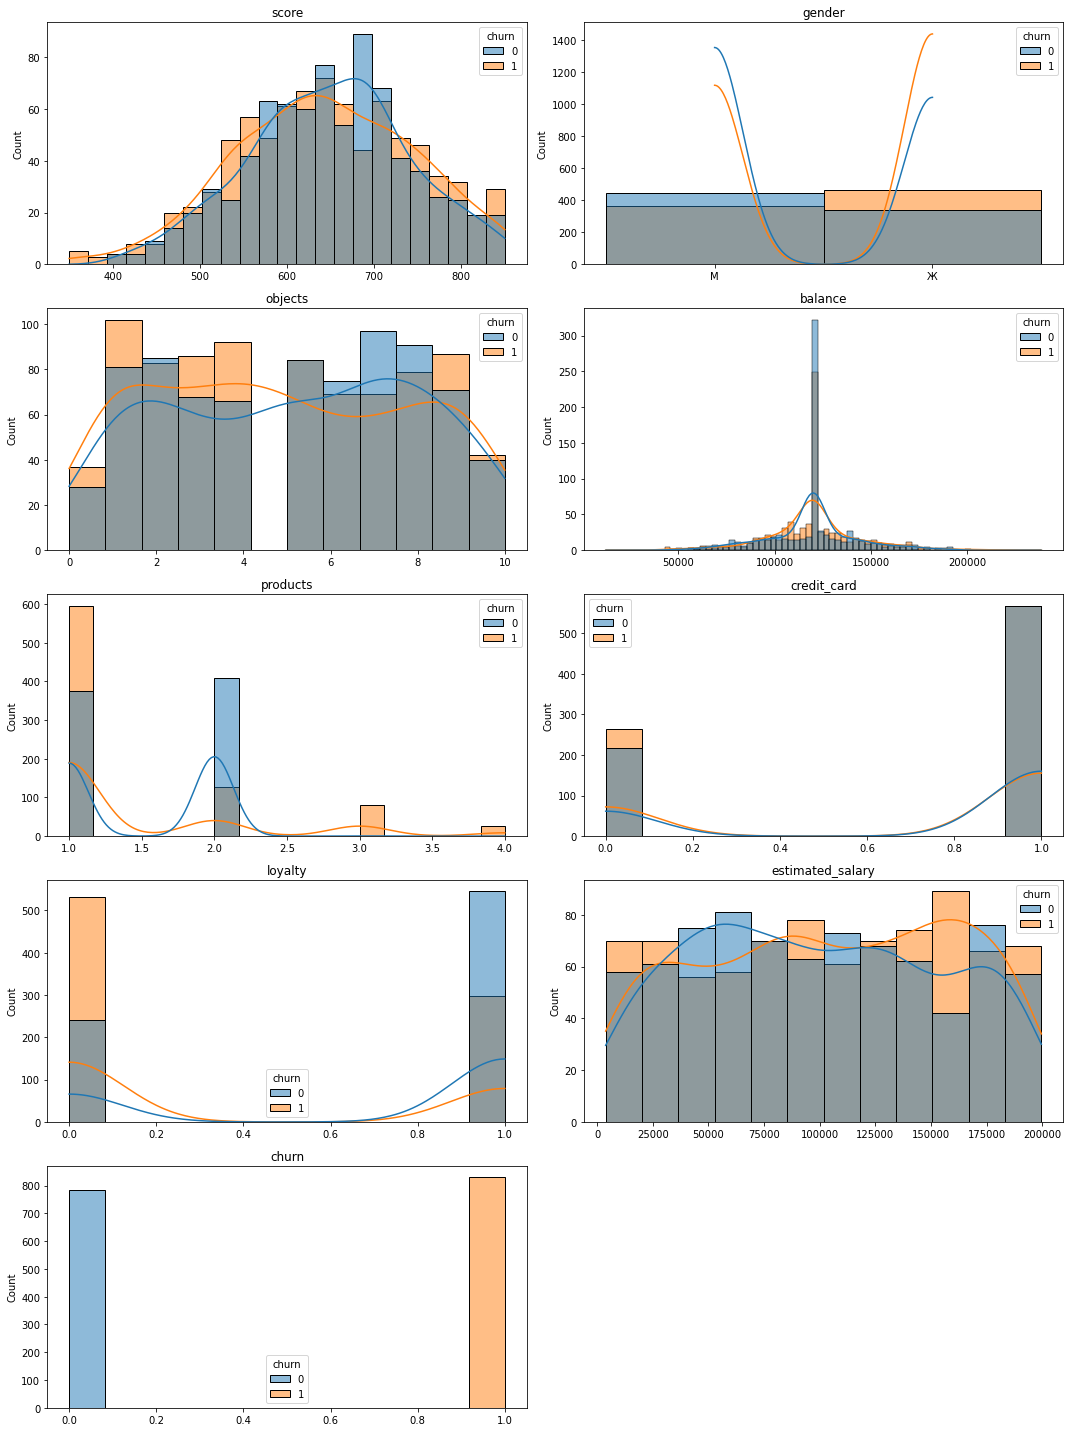

In [47]:
print('Распределение признаков для 46-60 лет')
feature_viz(data.query('age_category == "46-60"'), 'age')
display(data.query('age_category == "46-60"').describe())

Распределение признаков для 61+ лет


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,4.560000e+02,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,1.573452e+07,653.484649,67.464912,4.905702,119024.909890,1.506579,0.706140,0.809211,99817.860351,0.247807
std,7.248465e+04,96.336930,5.646245,2.986764,23819.396933,0.592963,0.456029,0.393355,56595.369847,0.432213
min,1.560942e+07,408.000000,61.000000,0.000000,27288.430000,1.000000,0.000000,0.000000,3837.080000,0.000000
25%,1.567605e+07,592.000000,63.000000,2.000000,112981.102500,1.000000,0.000000,1.000000,50343.395000,0.000000
50%,1.572762e+07,652.000000,66.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,99648.005000,0.000000
75%,1.579975e+07,721.000000,71.000000,8.000000,127267.047500,2.000000,1.000000,1.000000,147664.685000,0.000000
max,1.585836e+07,850.000000,92.000000,10.000000,187013.130000,4.000000,1.000000,1.000000,199493.380000,1.000000


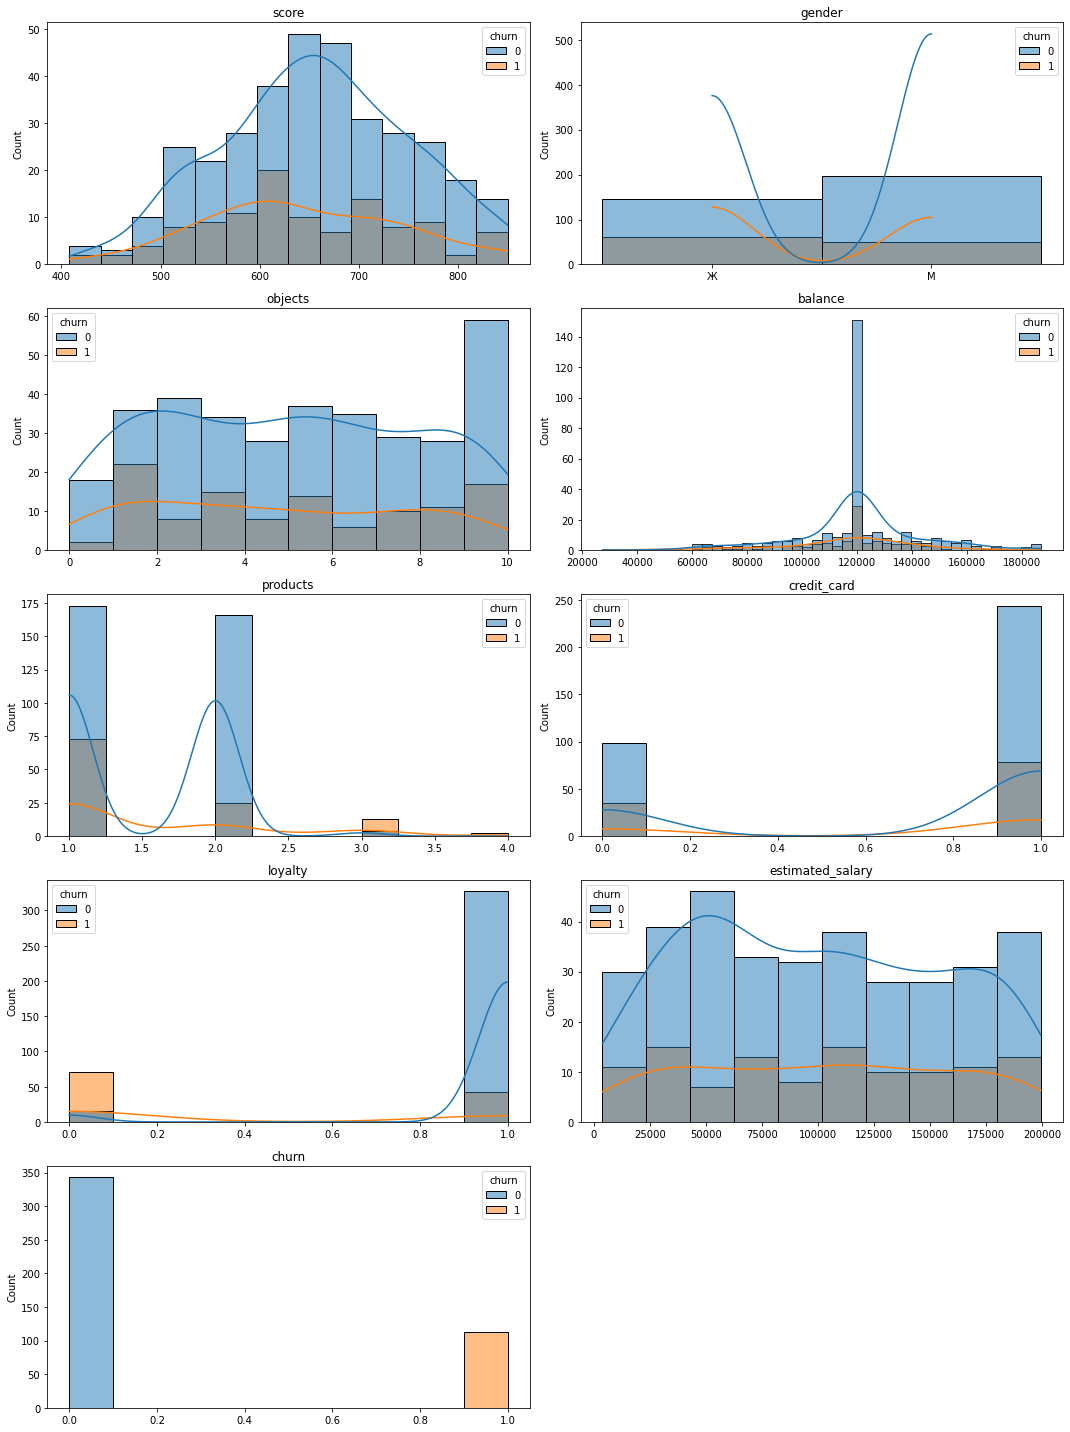

In [48]:
print('Распределение признаков для 61+ лет')
feature_viz(data.query('age_category == "61+"'), 'age')
display(data.query('age_category == "61+"').describe())

Выводы:

Категория 18-45:
Кол-во клиентов в категории - 7728
Средний отток - 14%


Категория 45-60:
Кол-во клиентов в категории - 1616
Средний отток - 51%

Категория 61+:
Кол-во клиентов в категории - 456
Средний отток - 25%


### Категории клиентов по доходу:

Создадим функцию, которая проверяет значение зарплаты клиента в нашем датафрейме и возвращает категорию (до 50000, от 50000 до 100000, выше 100000):

In [49]:
def salary_cat(data):
    if data['estimated_salary'] < 50000:
        return 'Низкий доход'
    
    elif (data['estimated_salary'] >= 50000 and data['estimated_salary'] <= 100000):
        return 'Средний доход'
    
    else:
        return 'Высокий доход'

Создадим новый столбец и применим функцию к датафрейму и выведем результат:

In [50]:
data['salary_category'] = data.apply(salary_cat, axis=1)
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,score_category,age_category,salary_category
0,15677338,619,Ярославль,Ж,42,2,119919.12,1,1,1,101348.88,1,Средний уровень,18-45,Высокий доход
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,Средний уровень,18-45,Высокий доход
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,Средний уровень,18-45,Высокий доход
3,15744090,699,Ярославль,Ж,39,1,119919.12,2,0,0,93826.63,0,Средний уровень,18-45,Средний доход
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,Высокий уровень,18-45,Средний доход


Посмотрим сколько клиентов попало в ту или иную категорию

In [51]:
data['salary_category'].value_counts()

Высокий доход    5010
Средний доход    2537
Низкий доход     2253
Name: salary_category, dtype: int64

Распределение признаков для Высокого дохода


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,5.010000e+03,5010.000000,5010.000000,5010.000000,5010.000000,5010.000000,5010.000000,5010.000000,5010.000000,5010.000000
mean,1.573430e+07,650.038523,38.771058,5.029940,119833.443824,1.536926,0.700599,0.512375,149667.565864,0.208383
std,7.163369e+04,97.022642,10.444220,2.901577,24246.378763,0.587293,0.458041,0.499897,29108.696859,0.406193
min,1.560852e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,100015.790000,0.000000
25%,1.567243e+07,583.000000,32.000000,3.000000,111096.397500,1.000000,0.000000,0.000000,124487.180000,0.000000
50%,1.573366e+07,651.500000,37.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,149304.985000,0.000000
75%,1.579684e+07,718.000000,44.000000,8.000000,127726.992500,2.000000,1.000000,1.000000,175091.515000,0.000000
max,1.585839e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000


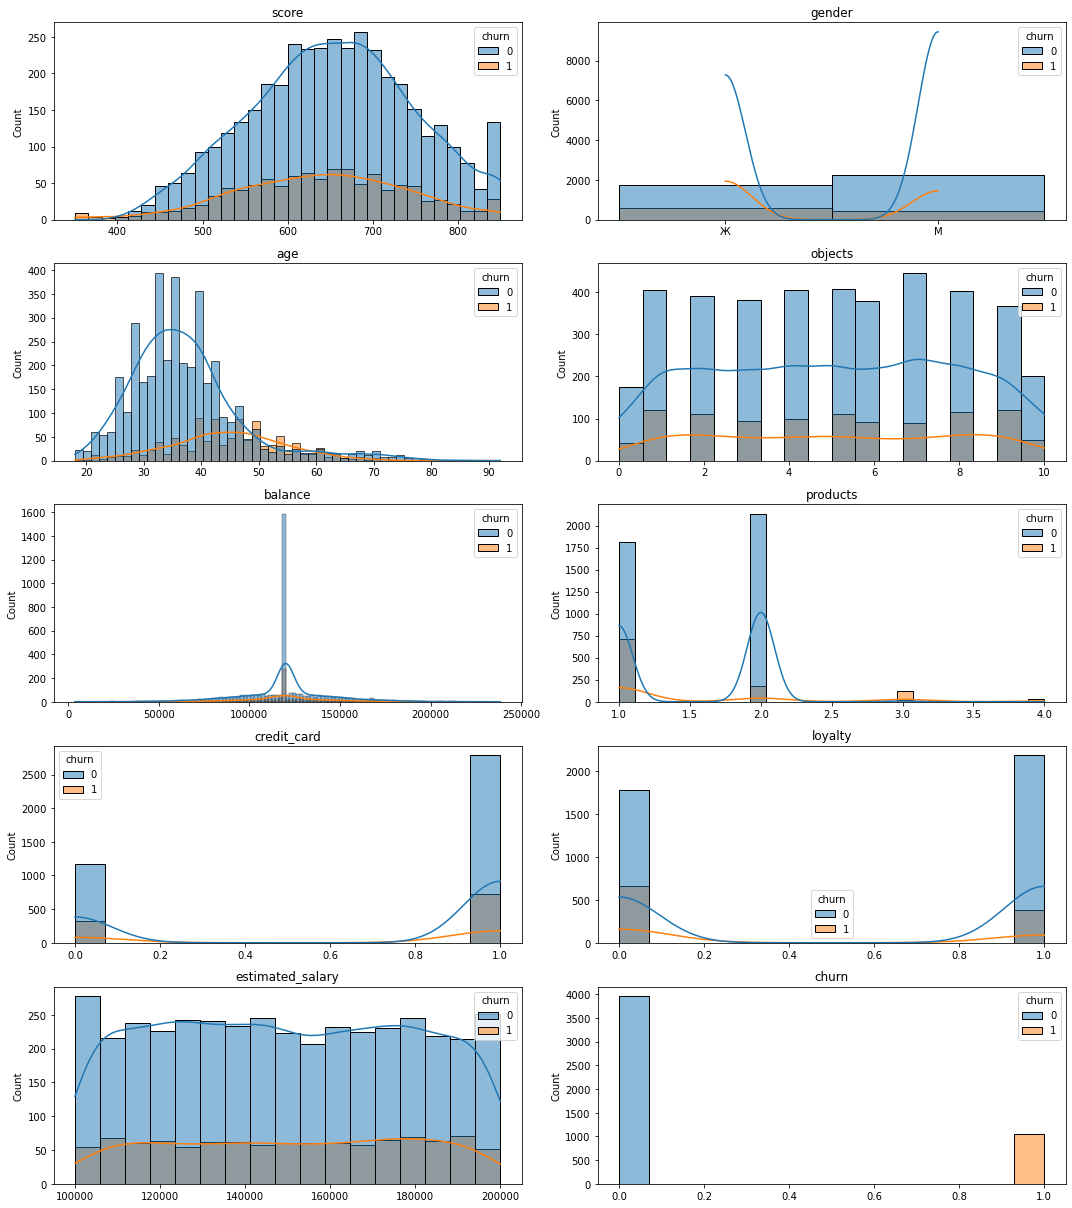

In [52]:
print('Распределение признаков для Высокого дохода')
feature_viz(data.query('salary_category == "Высокий доход"'))
display(data.query('salary_category == "Высокий доход"').describe())

Распределение признаков для Среднего дохода


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,2.537000e+03,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.00000
mean,1.573454e+07,649.422940,39.267245,5.012219,119761.257458,1.530548,0.709105,0.517146,74861.747643,0.19866
std,7.205628e+04,96.930943,10.351184,2.874382,24135.259060,0.581620,0.454265,0.499804,14304.847021,0.39907
min,1.560844e+07,365.000000,18.000000,0.000000,14262.800000,1.000000,0.000000,0.000000,50016.170000,0.00000
25%,1.567198e+07,583.000000,33.000000,3.000000,113193.510000,1.000000,0.000000,0.000000,62390.590000,0.00000
50%,1.573608e+07,653.000000,38.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,74965.610000,0.00000
75%,1.579646e+07,716.000000,44.000000,8.000000,127269.750000,2.000000,1.000000,1.000000,87000.390000,0.00000
max,1.585843e+07,850.000000,88.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,99984.860000,1.00000


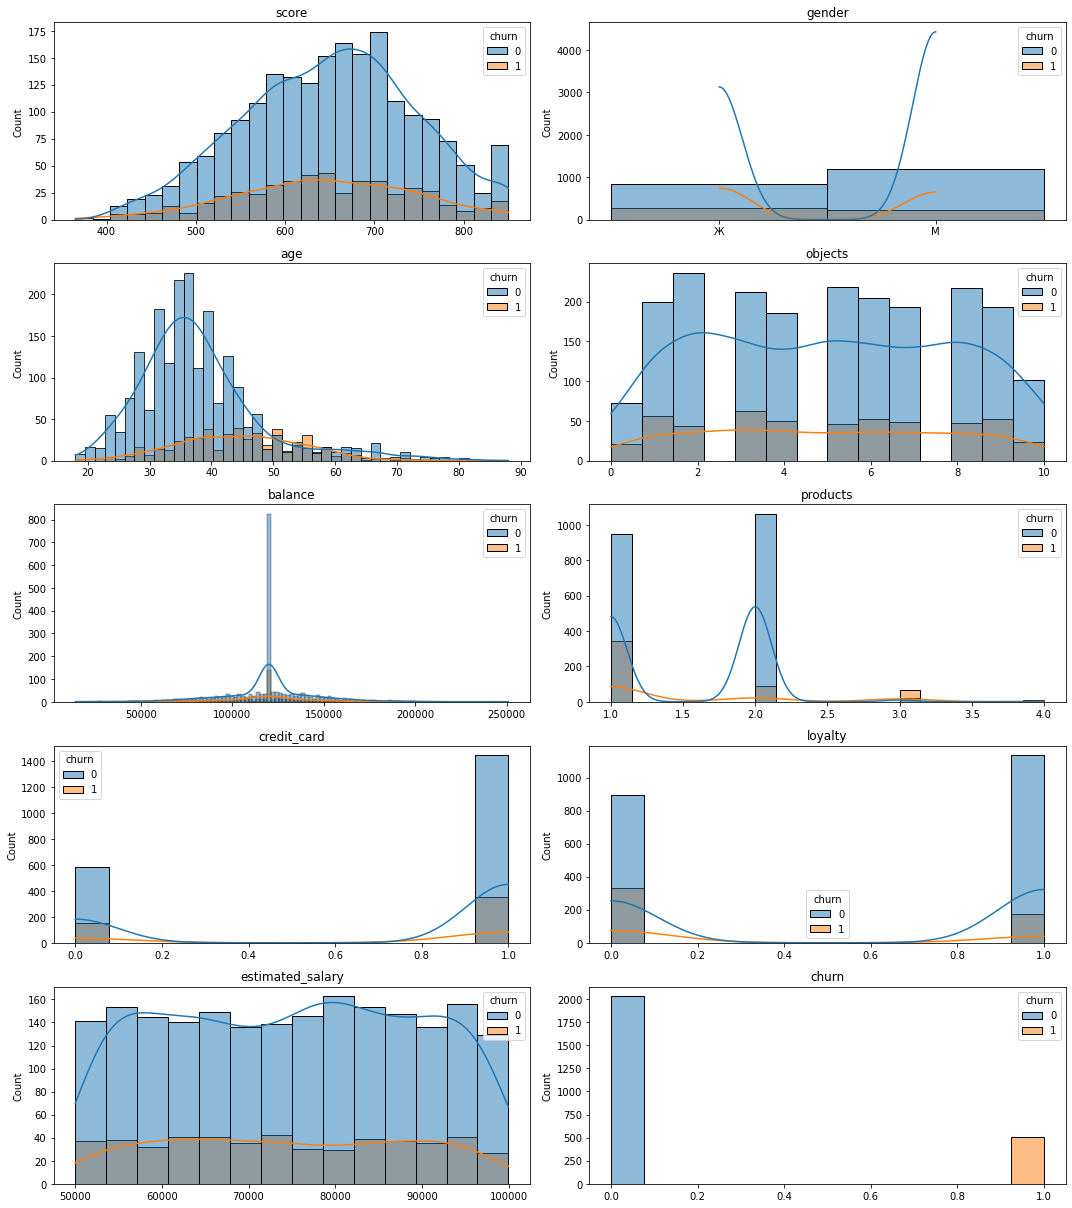

In [53]:
print('Распределение признаков для Среднего дохода')
feature_viz(data.query('salary_category == "Средний доход"'))
display(data.query('salary_category == "Средний доход"').describe())

Распределение признаков для Низкого дохода


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,2.253000e+03,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000
mean,1.573247e+07,652.380826,38.894807,4.988460,120139.342796,1.512650,0.712827,0.519308,26971.441163,0.202397
std,7.245082e+04,95.233744,10.729188,2.889137,23570.769786,0.575124,0.452543,0.499738,13406.929807,0.401876
min,1.560854e+07,395.000000,18.000000,0.000000,34013.630000,1.000000,0.000000,0.000000,3769.710000,0.000000
25%,1.566885e+07,586.000000,31.000000,2.000000,111574.410000,1.000000,0.000000,0.000000,15336.400000,0.000000
50%,1.573249e+07,651.000000,37.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,27022.570000,0.000000
75%,1.579436e+07,718.000000,44.000000,7.000000,128486.910000,2.000000,1.000000,1.000000,38411.790000,0.000000
max,1.585830e+07,850.000000,92.000000,10.000000,206663.750000,4.000000,1.000000,1.000000,49978.670000,1.000000


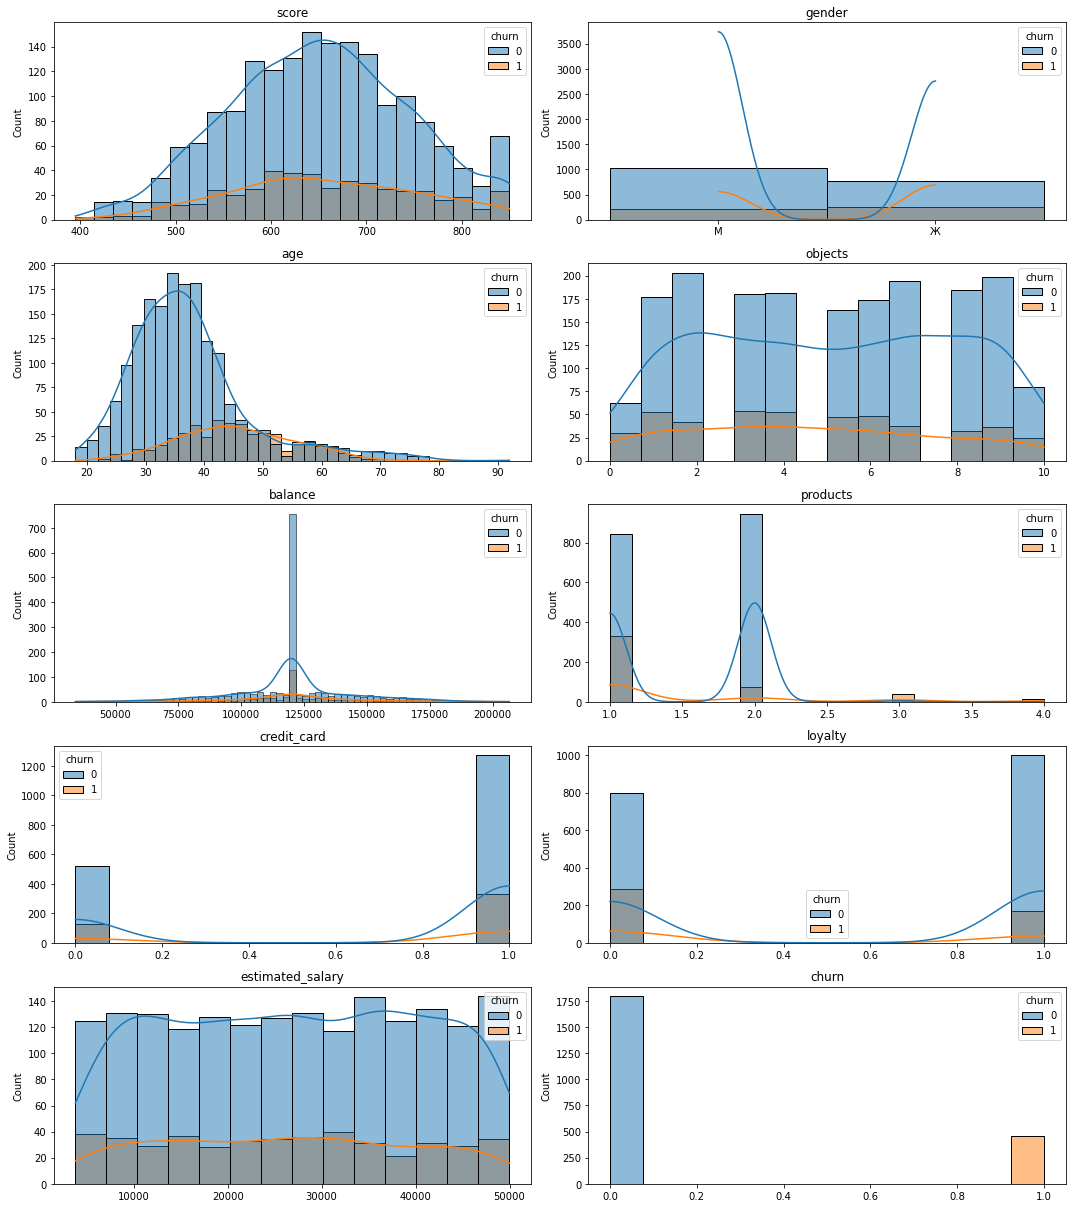

In [54]:
# выведем информацию и графики по категориям дохода
print('Распределение признаков для Низкого дохода')
feature_viz(data.query('salary_category == "Низкий доход"'))
display(data.query('salary_category == "Низкий доход"').describe())

Выводы:

Высокий доход:
Кол-во клиентов в категории - 5010
Средний отток - 21%


Средний доход:
Кол-во клиентов в категории - 2537
Средний отток - 20%


Низкий доход:
Кол-во клиентов в категории - 2253
Средний отток - 20%


### Категории по полу:

Посмотрим сколько клиентов попало в ту или иную категорию

In [55]:
data['gender'].value_counts()

М    5349
Ж    4451
Name: gender, dtype: int64

Распределение признаков по полу клиента: Женщины


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,4.451000e+03,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000,4451.000000
mean,1.573436e+07,650.512469,39.225343,4.973714,119328.957953,1.543249,0.702763,0.503033,102642.003799,0.251629
std,7.183380e+04,96.703457,10.574710,2.908875,24117.747516,0.604928,0.457093,0.500047,56158.837798,0.433998
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,3830.590000,0.000000
25%,1.567185e+07,584.000000,32.000000,2.000000,110630.155000,1.000000,0.000000,0.000000,54658.635000,0.000000
50%,1.573494e+07,652.000000,38.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,103381.470000,0.000000
75%,1.579688e+07,717.000000,45.000000,7.000000,127292.690000,2.000000,1.000000,1.000000,149917.330000,1.000000
max,1.585843e+07,850.000000,85.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000


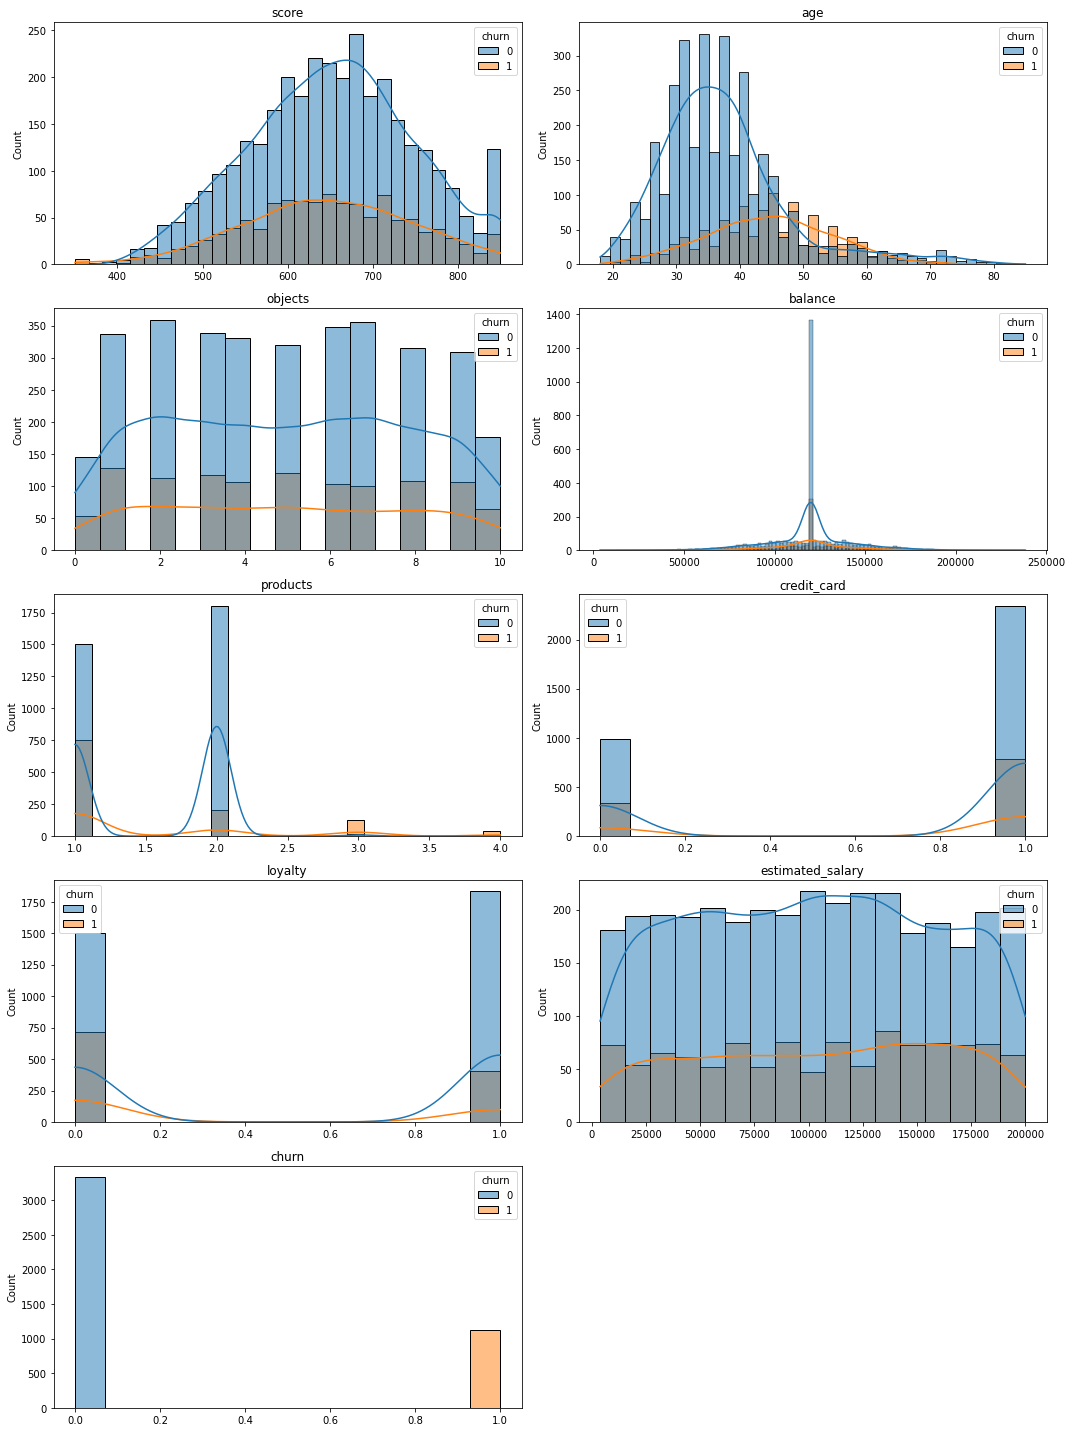

In [56]:
print('Распределение признаков по полу клиента: Женщины')
feature_viz(data.query('gender == "Ж"'), 'gender')
display(data.query('gender == "Ж"').describe())

Распределение признаков по полу клиента: Мужчины


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,5.349000e+03,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000
mean,1.573359e+07,650.338755,38.680501,5.050851,120347.842812,1.518415,0.707983,0.525332,101638.784218,0.165265
std,7.201273e+04,96.498910,10.408926,2.876678,24007.621326,0.564043,0.454733,0.499405,56489.601384,0.371454
min,1.560844e+07,350.000000,18.000000,0.000000,16893.590000,1.000000,0.000000,0.000000,3769.710000,0.000000
25%,1.567080e+07,583.000000,32.000000,3.000000,112666.670000,1.000000,0.000000,0.000000,53353.360000,0.000000
50%,1.573336e+07,651.000000,37.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,100433.830000,0.000000
75%,1.579582e+07,718.000000,43.000000,8.000000,127997.830000,2.000000,1.000000,1.000000,150218.110000,0.000000
max,1.585838e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199953.330000,1.000000


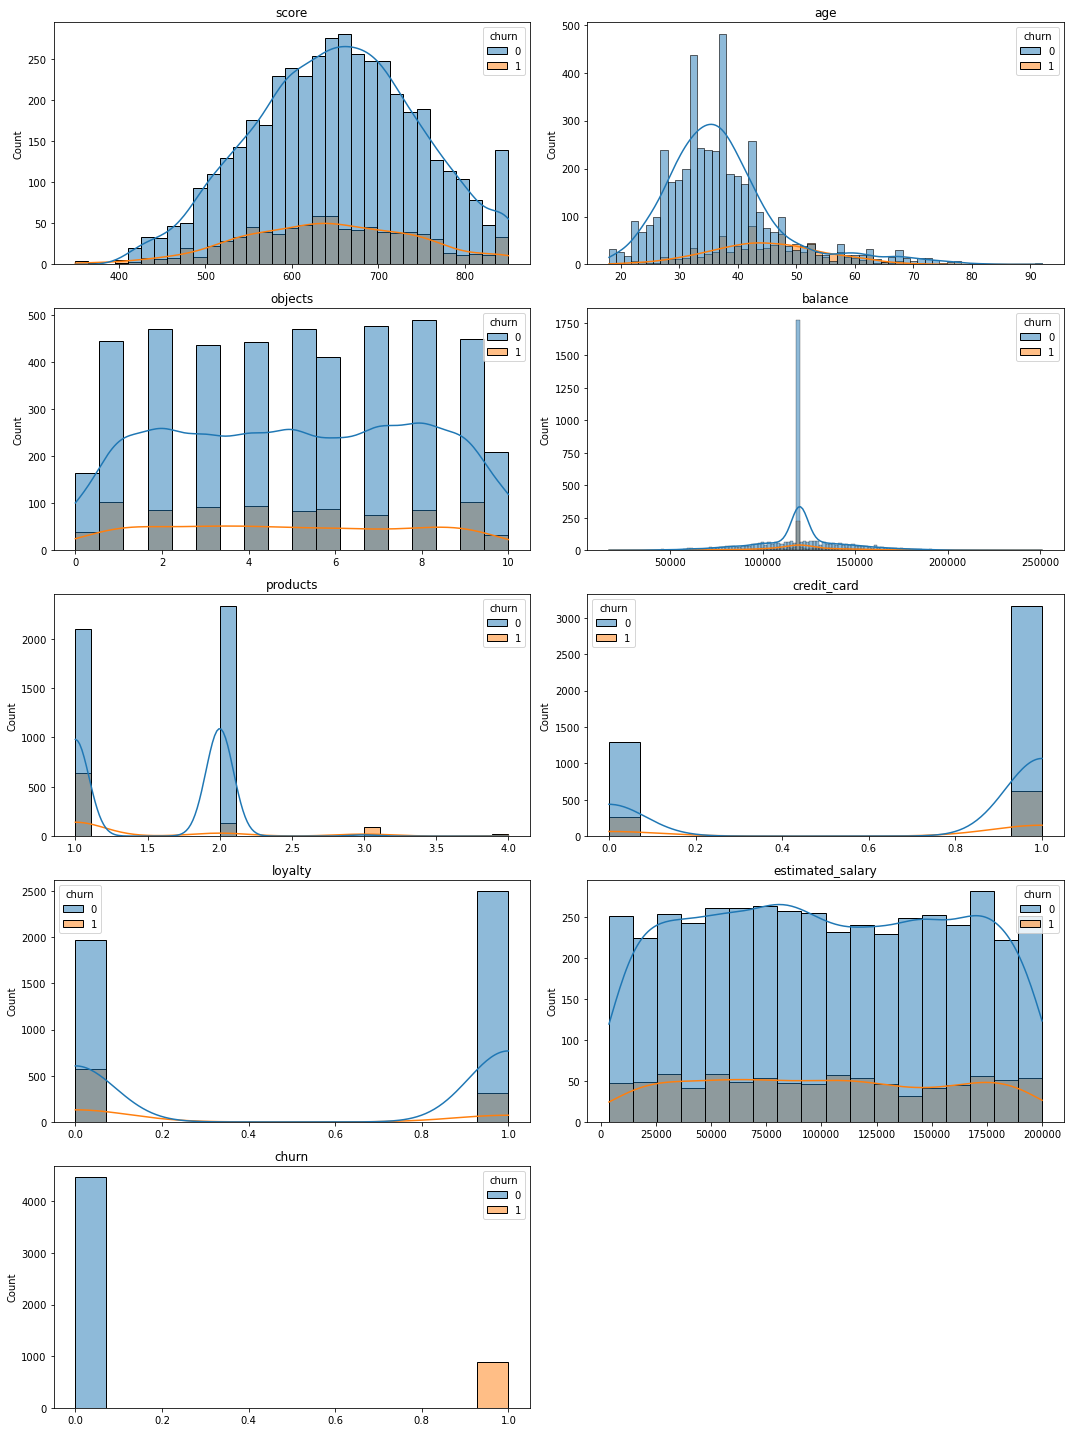

In [57]:
print('Распределение признаков по полу клиента: Мужчины')
feature_viz(data.query('gender == "М"'), 'gender')
display(data.query('gender == "М"').describe())

Выводы:

Женщины:
Кол-во клиентов в категории - 4451
Средний отток - 25%


Мужчины:
Кол-во клиентов в категории - 5349
Средний отток - 16%


### Категории по городу:

Посмотрим сколько клиентов попало в ту или иную категорию:

In [58]:
data['city'].value_counts()

Ярославль         4902
Ростов Великий    2460
Рыбинск           2438
Name: city, dtype: int64

Распределение признаков для города: Ярославль


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,4.902000e+03,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000
mean,1.573371e+07,649.377397,38.516320,5.007548,119963.481330,1.529580,0.706650,0.516320,102138.666758,0.163607
std,7.137919e+04,96.959571,10.467234,2.887071,22858.397115,0.571586,0.455344,0.499785,56017.646535,0.369956
min,1.560845e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,3769.710000,0.000000
25%,1.567157e+07,582.000000,31.000000,2.000000,118666.845000,1.000000,0.000000,0.000000,55036.497500,0.000000
50%,1.573453e+07,653.000000,37.000000,5.000000,119919.120000,1.000000,1.000000,1.000000,101296.965000,0.000000
75%,1.579532e+07,717.000000,43.000000,7.000000,121813.402500,2.000000,1.000000,1.000000,150126.660000,0.000000
max,1.585840e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199929.170000,1.000000


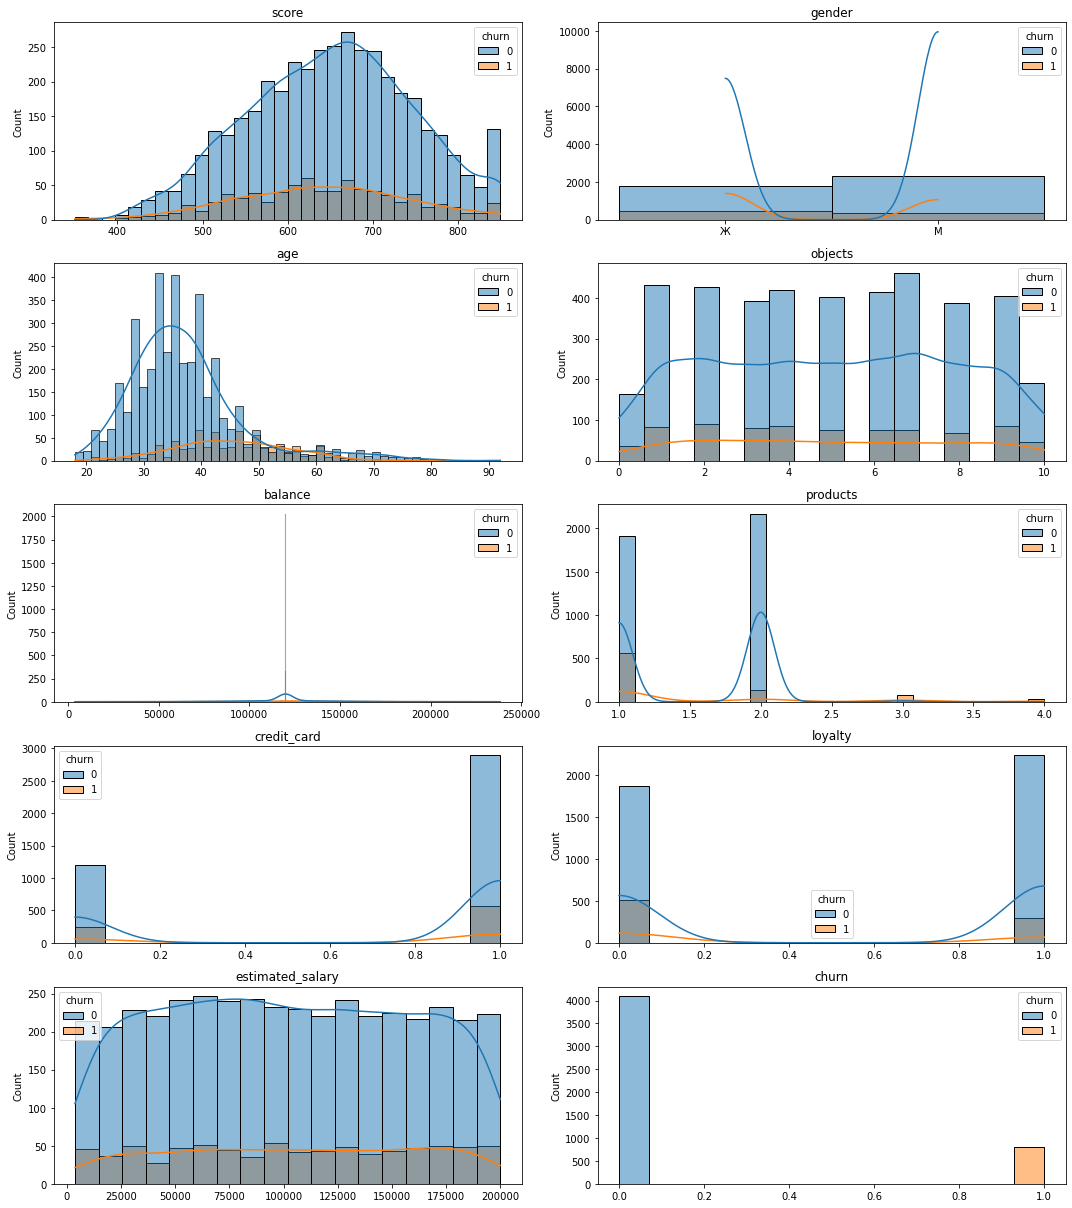

In [59]:
print('Распределение признаков для города: Ярославль')
feature_viz(data.query('city == "Ярославль"'))
display(data.query('city == "Ярославль"').describe())

Распределение признаков для города: Ростов Великий


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,2.460000e+03,2460.000000,2460.000000,2460.000000,2460.00000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,1.573346e+07,651.288211,39.774797,5.001220,119788.40689,1.519512,0.714634,0.497967,103092.555354,0.323984
std,7.327714e+04,98.109322,10.512744,2.936012,27029.67003,0.621580,0.451680,0.500098,57110.018355,0.468089
min,1.560852e+07,350.000000,18.000000,0.000000,27288.43000,1.000000,0.000000,0.000000,4027.020000,0.000000
25%,1.567012e+07,584.000000,32.000000,2.000000,102782.17000,1.000000,0.000000,0.000000,53495.412500,0.000000
50%,1.573293e+07,651.000000,38.000000,5.000000,119708.67500,1.000000,1.000000,0.000000,103678.940000,0.000000
75%,1.579860e+07,722.000000,45.000000,8.000000,137650.13500,2.000000,1.000000,1.000000,152473.602500,1.000000
max,1.585839e+07,850.000000,84.000000,10.000000,214346.96000,4.000000,1.000000,1.000000,199970.740000,1.000000


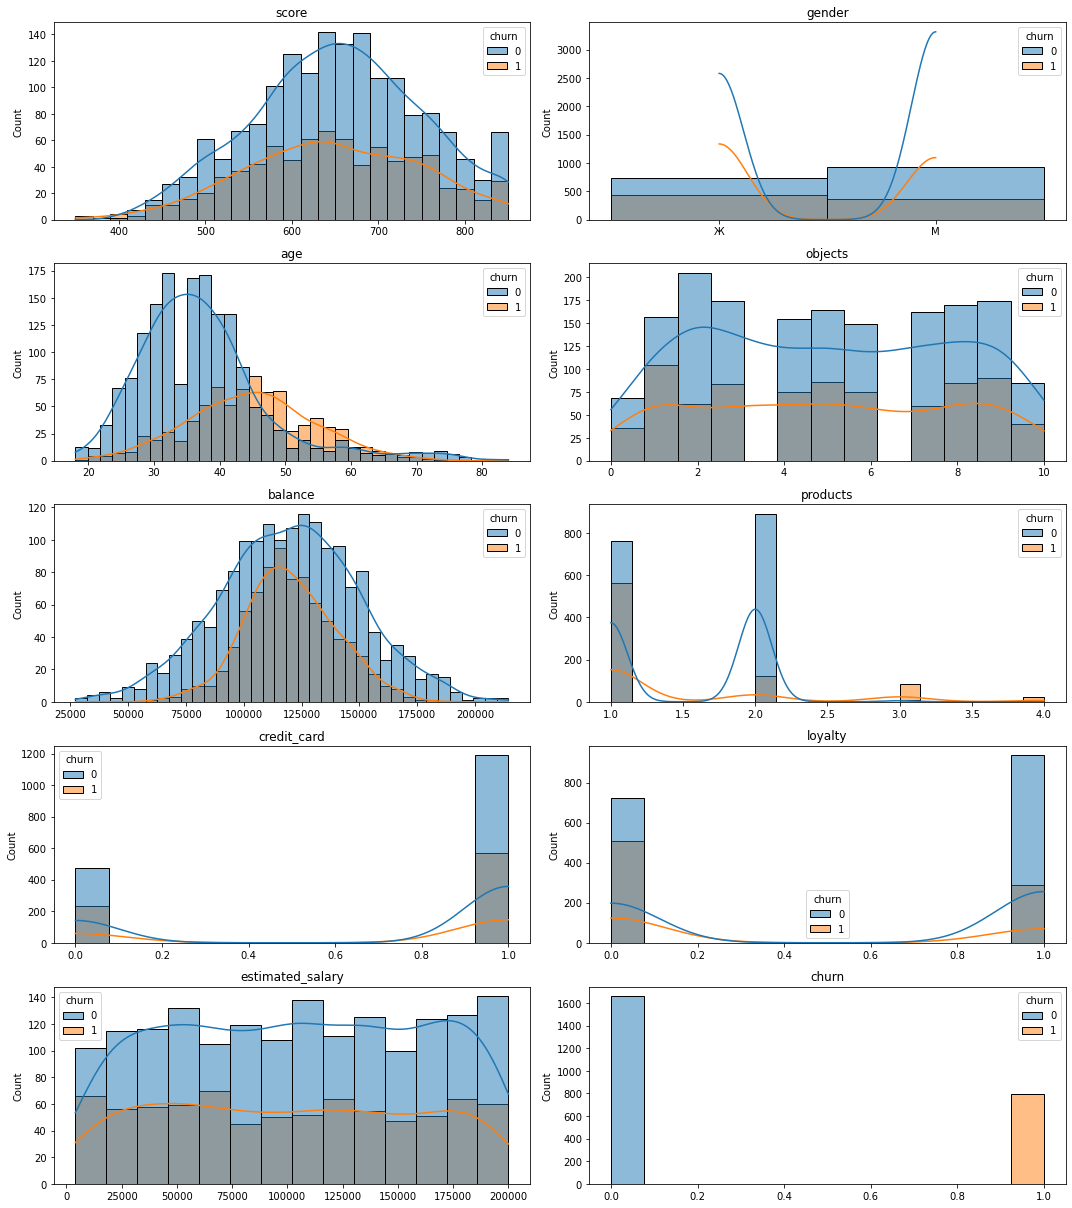

In [60]:
print('Распределение признаков для города: Ростов Великий')
feature_viz(data.query('city == "Ростов Великий"'))
display(data.query('city == "Ростов Великий"').describe())

Распределение признаков для города: Рыбинск


C:\Users\Комп\AppData\Local\Temp\ipykernel_23440\3780311680.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,2.438000e+03,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000
mean,1.573487e+07,651.630845,38.901148,5.047170,119824.994512,1.540197,0.694422,0.530353,100998.353187,0.166120
std,7.167768e+04,94.277173,10.456255,2.855685,23237.379461,0.565584,0.460746,0.499180,56203.279155,0.372264
min,1.560844e+07,350.000000,18.000000,0.000000,12459.190000,1.000000,0.000000,0.000000,3829.130000,0.000000
25%,1.567244e+07,587.250000,32.000000,3.000000,118202.980000,1.000000,0.000000,0.000000,53015.020000,0.000000
50%,1.573474e+07,651.000000,37.000000,5.000000,119919.120000,2.000000,1.000000,1.000000,101153.800000,0.000000
75%,1.579657e+07,715.000000,44.000000,8.000000,121047.735000,2.000000,1.000000,1.000000,148443.420000,0.000000
max,1.585843e+07,850.000000,88.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


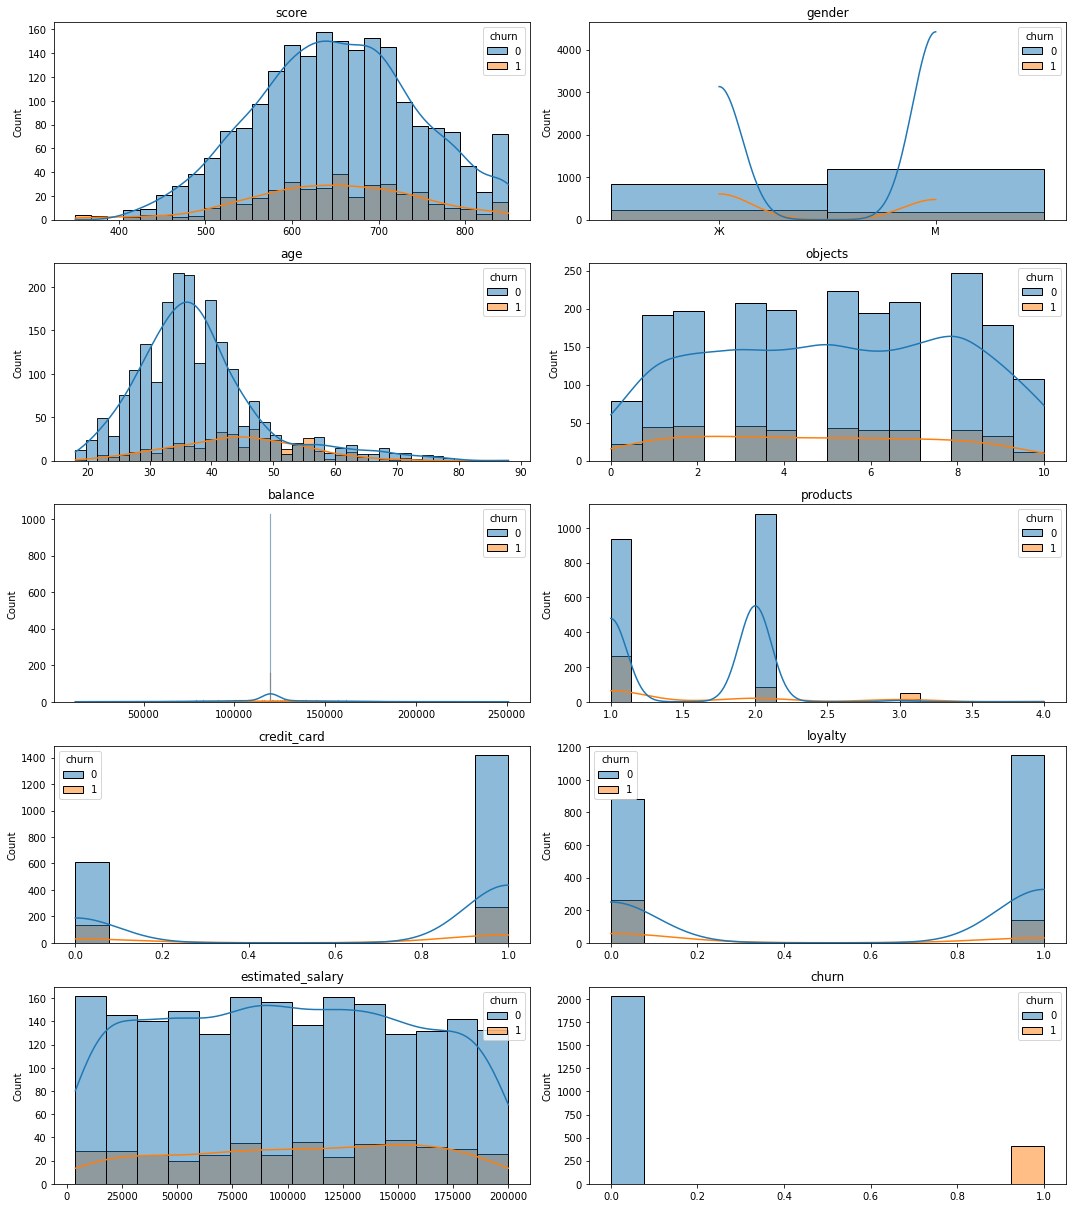

In [61]:
print('Распределение признаков для города: Рыбинск')
feature_viz(data.query('city == "Рыбинск"'))
display(data.query('city == "Рыбинск"').describe())

Выводы:

Ярославль:
Кол-во клиентов в категории - 4902
Средний отток - 16%

Рыбинск:
Кол-во клиентов в категории - 2438
Средний отток - 16%


Ростов Великий:
Кол-во клиентов в категории - 2460
Средний отток - 32%


### Категории по активности:

Выведем количества оставшихся и ушедших клиентов

In [62]:
data['loyalty'].value_counts()

1    5049
0    4751
Name: loyalty, dtype: int64

In [63]:
data.groupby('loyalty').agg('mean')

,user_id,score,age,objects,balance,products,credit_card,estimated_salary,churn
loyalty,,,,,,,,,
0,1.573395e+07,647.695222,37.998106,5.101663,120279.998478,1.523469,0.711008,102807.112547,0.269838
1,1.573393e+07,652.979402,39.802931,4.935037,119513.474011,1.535552,0.700535,101423.811444,0.142999


Выводы:

Активные клиенты:
Кол-во клиентов в категории - 5049 
Средний отток - 14%


Неактивные клиенты:
Кол-во клиентов в категории - 4751
Средний отток - 26%

### Количество объектов в собственности:

Посмотрим количество клиентов по количеству объектов:

In [64]:
data['objects'].value_counts()

2     1028
1     1012
7     1009
8      999
5      993
3      984
4      973
9      967
6      950
10     482
0      403
Name: objects, dtype: int64

In [65]:
data.groupby('objects').agg('mean')

,user_id,score,age,balance,products,credit_card,loyalty,estimated_salary,churn
objects,,,,,,,,,
0,1.573583e+07,651.580645,39.243176,119695.177320,1.431762,0.647643,0.531017,104867.928387,0.230769
1,1.573518e+07,649.092885,39.503953,119074.769259,1.489130,0.677866,0.549407,102702.615860,0.227273
2,1.573810e+07,652.694553,39.066148,120485.707588,1.588521,0.705253,0.535992,100181.327393,0.192607
3,1.573709e+07,649.944106,39.029472,119595.877185,1.534553,0.723577,0.519309,100096.928780,0.213415
4,1.573277e+07,651.428571,38.155190,118961.156218,1.517986,0.716341,0.506680,101483.615427,0.206578
5,1.572802e+07,650.165156,39.256798,120733.431158,1.553877,0.689829,0.498489,103190.028761,0.205438
6,1.573361e+07,647.077895,38.875789,119875.824074,1.520000,0.716842,0.516842,100908.333263,0.202105
7,1.573403e+07,649.090188,38.425173,120650.808999,1.530228,0.704658,0.520317,103128.937869,0.174430
8,1.573106e+07,648.492492,38.467467,120283.429620,1.520521,0.726727,0.505506,103662.581201,0.194194


Самый низкий процент оттока у клиентов с 7-ю объектами, самый высокий у клиентов без объектов собственности. С учетом разброса в количестве клиентов каждой их представленных категорий владения собственностью, разброс очень мал, скорее всего этот фактор на отток никак не влияет.

### Количество продуктов Банка:

Посмотрим количество клиентов по количеству используемых продуктов:

In [66]:
data['products'].value_counts()

1    4994
2    4481
3     265
4      60
Name: products, dtype: int64

In [67]:
data.groupby('products').agg('mean')

,user_id,score,age,objects,balance,credit_card,loyalty,estimated_salary,churn
products,,,,,,,,,
1,1.573274e+07,648.879055,39.655186,4.973168,119927.607505,0.704245,0.503805,101247.906914,0.277333
2,1.573500e+07,652.270922,37.774158,5.060254,119827.807509,0.706985,0.533586,102848.105981,0.075876
3,1.574176e+07,647.358491,43.203774,5.003774,119637.999774,0.713208,0.426415,104698.800981,0.826415
4,1.571936e+07,653.583333,45.683333,5.300000,121714.263000,0.683333,0.483333,104763.723333,1.000000


Выводы:

Клиенты с одним продуктом - отток 27%,

Клиенты с двумя продуктами - отток 7,5%,

Клиенты с тремя продуктами - отток 83%,

Клиенты с четырьмя продуктами ушли из Банка все.

Оптимальный вариант - 2 продукта.

## Сегментация отточных клиентов:

Теперь посмотрим, на какие сегменты можно распределить отточных клиентов:

Первый сегмент - возраст 45-60 лет:

- Кол-во клиентов в категории - 1616 (16,5%)
- Средний баланс - 119,7 тыс.
- Средняя активность - 52%
- Средний отток - 51%

Второй сегмент - женщины:

- Кол-во клиентов в категории - 4451 (45,4%)
- Средний возраст - 39 лет
- Средний баланс - 119,3 тыс.
- Активность - 50%
- Средний отток - 25%

Третий сегмент - клиенты из Ростов Великий:

- Кол-во клиентов в категории - 2460 (25%)
- Средний возраст - 39-40 лет
- Средний баланс - 120 тыс.
- Кредитные карты - 71%
- Активность - 50%
- Средний отток - 32%

Четвертый сегмент - низкий уровень активности:

- Кол-во клиентов в категории - 4751 (48,5%)
- Средний баланс - 120 тыс.
- Средний возраст - 39-40 лет
- Средний отток - 26%

Пятый сегмент - лиенты с 3-мя и 4-мя продуктами:

- кол-во клиентов 325 (3%)
- Средний отток достигает 82%, чаще всего это женщины и средний возраст 43 года 
-   4-мя продуктами показатель среднего оттока достигает 100%, в основном это женщины и средний возраст 45-46 лет

То есть, почти все клиенты, которые начинают пользоваться больше чем двумя продуктами попадают в отток.

### Вывод по категоризации:

Видна связь оттока с пятью признаками клиента:

- Возраст: оттоку более всего подвержены клиенты в возрасте от 45 до 60 лет (51%);
- Город: самый большой отток в Ростове Великом (32%);
- Пол: оттоку больше подвержены женщины (25%);
- Активность: менее активные клиенты, что вполне логично, более подвержены оттоку (26%);
- Количество продуктов: оптимальное количество - 2 продукта, более двух резко увеличивают вероятность оттока (в случае с 4-мя продуктами вплоть до 100%)

Взаимосвязь остальных признаков с оттоком не выявлена.

## Проверка гипотез

### Проверка гипотезы различия дохода между теми клиентами, которые ушли, и теми, которые остались.

Сформулируем нулевую и альтернативную гипотезы:

- H0: доходы между клиентами, которые ушли, и клиентами, которые остались, одинаковы
- H1: доходы между клиентами, которые ушли, и клиентами, которые остались, различны

Уровень значимости зададим обычный 0,05: 

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Мы помним, что количество пользователей одного и двух продуктов сопоставимо.

Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод st.stats.ttest_ind.

Если p-value будет меньше выбранного уровня значимости, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [68]:
alpha = .05   # критический уровень статистической значимости    
results = st.stats.ttest_ind(data[data['churn'] == 0]['estimated_salary'], 
                             data[data['churn'] == 1]['estimated_salary'])

print('p-значение: ', results.pvalue)   

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.3659824495207541
Не получилось отвергнуть нулевую гипотезу


Получилось, что доходы между клиентами, которые ушли, и клиентами, которые остались, скорее всего не различаются.

### Проверка гипотезы различия в факте наличия кредитной карты между теми клиентами, которые ушли, и теми, которые остались.

Сформулируем нулевую и альтернативную гипотезы:

- H0: наличие КК среди клиентов, которые ушли, и клиентов, которые остались, одинаковое
- H1: наличие КК среди клиентов, которые ушли, и клиентов, которые остались, различно

Проверим гипотезы так же:

In [69]:
alpha = .05   # критический уровень статистической значимости    
results = st.stats.ttest_ind(data[data['churn'] == 0]['credit_card'], 
                             data[data['churn'] == 1]['credit_card'])

print('p-значение: ', results.pvalue)   

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5438627140713232
Не получилось отвергнуть нулевую гипотезу


Получается, что наличие КК среди клиентов, которые ушли, и клиентов, которые остались, скорее всего одинаковое.

## Общий вывод.

Из всего вышеизложенного можно сделать вывод о том, что портрет клиента, склонного к уходу из банка следующий:

- скорее всего это женщина
- возраст от 45 до 60 лет
- количество продуктов - более 2-х
- клиент неактивный
- велика вероятность того, что проживает она в Ростове Великом.

Какие меры можно предпринять, чтобы снизить отток:

- Провести аудит в городе Ростове Великом - этот город имеет отток 50%, стоит выяснить причины: проверить компетенции сотрудников, провести опрос клиентов, которые уходят из Банка; проверить, корректно ли работает ПО, горячая линия в этом городе, не появился ли какой-то конкурент на территории, который влияет на отток.

- Необходимо узнать причину что не устраивает клиентов при использовании 3-4 продуктов и исправить проблему. При необходимости оптимизировать продукты клиентов: если у клиента 3 кредита - предложить объединить их, если активы слишком разбросаны, предложить какой-то общий накопительный счет. Видимо клиенты, путаясь в множестве продуктов, предпочитают рефинансироваться или собрать все деньги в одном месте - проконтролировать, чтобы этим местом был наш Банк.

- провести промо-акцию для клиентов женского пола и возраста 45-60 лет: возможно запустить совместные скидки в продуктовых магазинах или аптеках, на проездные билеты - в общем в тех сферах, в которых заинтересована такая категория клиентов. Можно так же промониторить среду банковских офисов на доступность для клиентов старшего возраста (как правило это люди слабовидящие, слабослышащие - возможно им просто физически неудобно обслуживаться в необорудованных офисах)

- постараться активировать клиентов - возможно предложить скачать приложение Банка, провести в нем какие-то операции, чтобы клиент активнее взаимодействовал с Банком.



